In [2]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [10]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [11]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [12]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [13]:
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean

In [14]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [15]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')

In [20]:
maps_voxel_res.shape

(314, 146, 91, 3)

In [3]:
###########################
### Get highres anatomy ###
###########################

### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)

### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_highres = ants.resample_image(fixed,(1256, 584, 363),use_voxels=True)

In [4]:
luke_mean.shape

(1024, 512, 256)

In [5]:
highres_anat = ants.registration(fixed_highres, luke_mean, type_of_transform='Affine')

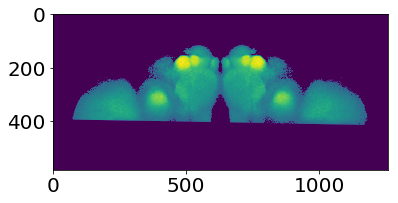

In [8]:
plt.imshow(highres_anat['warpedmovout'][:,:,100].T)

In [9]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210817_luke_mean_highres.nii"
nib.Nifti1Image(highres_anat['warpedmovout'].numpy(), np.eye(4)).to_filename(save_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 313.5, 145.5, -0.5)

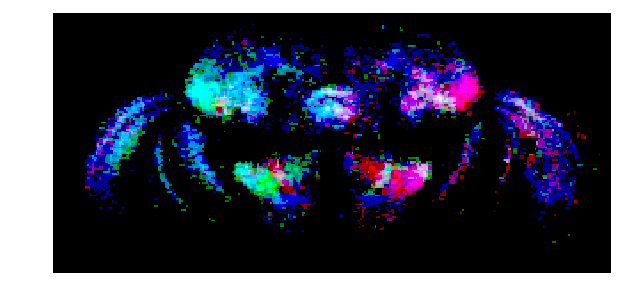

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,:,60,:]*20,0,1))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 313.5, 90.5, -0.5)

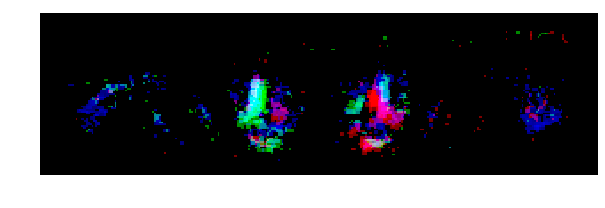

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,100,:,:]*20,0,1))
plt.axis('off')

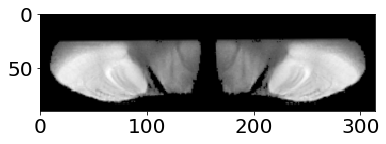

In [56]:
plt.imshow(out['warpedmovout'][:,z,:].T,cmap='gray')

In [51]:
out['warpedmovout'].shape

(314, 146, 91)

In [76]:
### MAKE ALPHA ###
signals = maps_voxel_res.numpy()
alpha = np.ones((314, 146, 91))
alpha[np.where(np.sum(signals,axis=-1)==0)]=0
signals_alpha = np.concatenate((signals,alpha[..., np.newaxis]),axis=-1)

In [ ]:
z=70
plt.figure(figsize=(10,10))
plt.imshow(out['warpedmovout'][:,z,:].T,cmap='gray')
plt.imshow(np.swapaxes(signals_alpha[:,z,:,:]*20,0,1))
plt.axis('off')

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
#edges = binary_dilation(edges, iterations=1)
#edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
plt.imshow(np.swapaxes(edges_,0,1)*10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


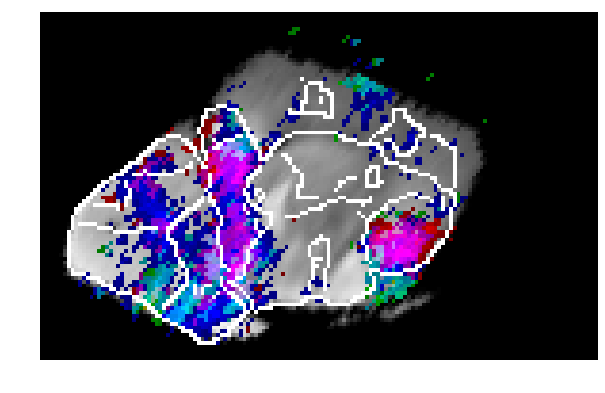

In [106]:
z=200
plt.figure(figsize=(10,10))
plt.imshow(out['warpedmovout'][z,:,:].T,cmap='gray')
plt.imshow(np.swapaxes(signals_alpha[z,:,:,:]*20,0,1))
plt.axis('off')

# get edges for this slice
edges = cv2.Canny(atlas_int[z,:,:],1,1)
#edges = binary_dilation(edges, iterations=1)
#edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
plt.imshow(np.swapaxes(edges_,0,1)*10000)

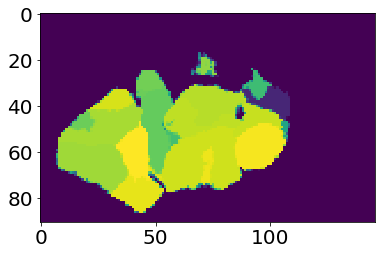

In [107]:
plt.imshow(atlas_int[z,:,:].T)

In [16]:
##################
### Load Atlas ###
##################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed_nearest_neighbor.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
#atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
atlas = ants.resample_image(atlas,(.5,.5,.5),use_voxels=False)

In [17]:
atlas.shape

(1256, 584, 363)

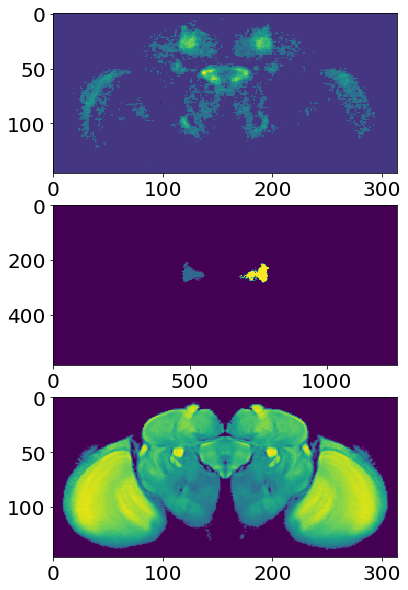

In [12]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(maps_voxel_res[:,:,z,2].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

In [90]:
maps_voxel_res.shape

(314, 146, 91, 3)

In [19]:
atlas = atlas.numpy()

In [20]:
atlas_int = atlas.astype('uint8')
atlas_int.shape
roi_ints = np.unique(atlas_int)

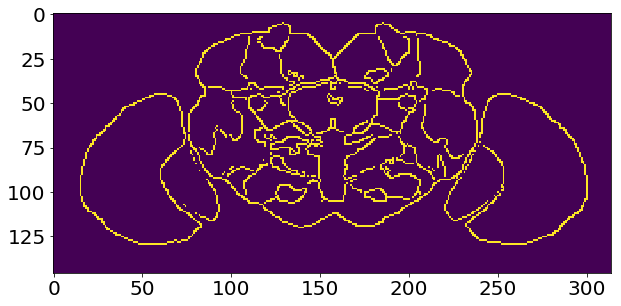

In [30]:
plt.figure(figsize=(10,10))
edges = cv2.Canny(atlas_int[:,:,50],1,1)
#edges = binary_dilation(edges, iterations=1)
#edges = scipy.ndimage.median_filter(edges,1)
#plt.imshow(edges[350:900,50:450].T)
plt.imshow(edges.T)

In [48]:
atlas_int.shape

(1256, 584, 363)

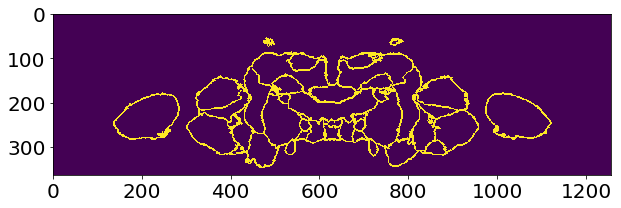

In [49]:
plt.figure(figsize=(10,10))
edges = cv2.Canny(atlas_int[:,200,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
#plt.imshow(edges[350:900,50:450].T)
plt.imshow(edges.T)

In [18]:
maps_voxel_high_res = ants.resample_image(maps_voxel_res,(1256, 584, 363, 3),use_voxels=True)
maps_voxel_high_res.shape

(1256, 584, 363, 3)

In [15]:
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
edges_.shape

(1256, 584, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


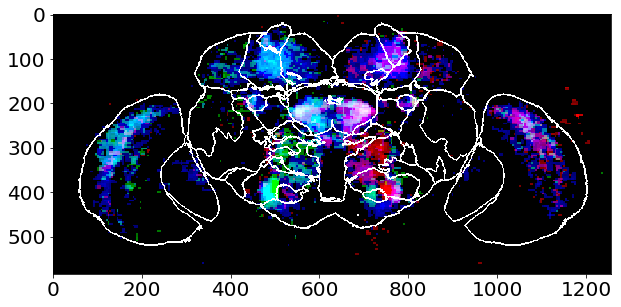

In [19]:
plt.figure(figsize=(10,10))
z=200

# get edges for this slice
edges = cv2.Canny(atlas_int[:,:,z],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,:,z,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


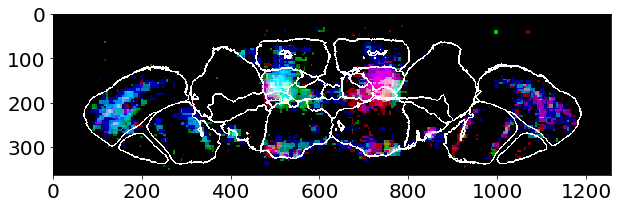

In [112]:
plt.figure(figsize=(10,10))
z=300

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

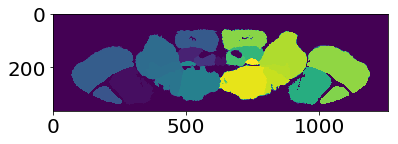

In [114]:
plt.imshow(atlas_int[:,z,:].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


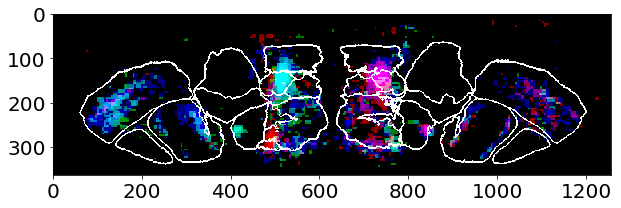

In [57]:
plt.figure(figsize=(10,10))
z=325

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


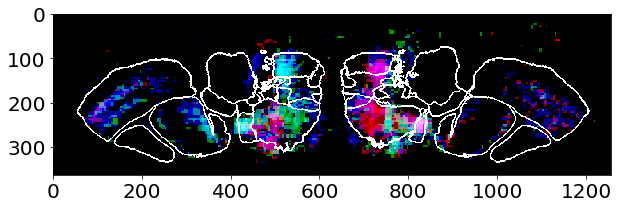

In [53]:
plt.figure(figsize=(10,10))
z=350

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


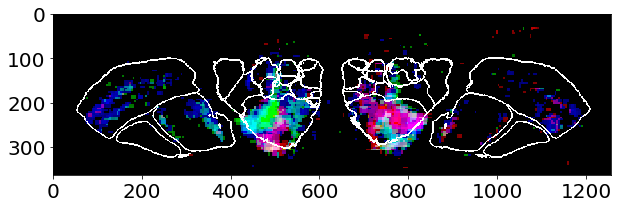

In [55]:
plt.figure(figsize=(10,10))
z=375

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


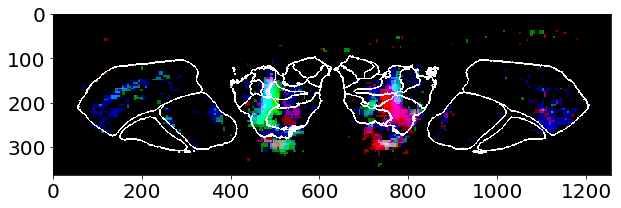

In [54]:
plt.figure(figsize=(10,10))
z=400

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

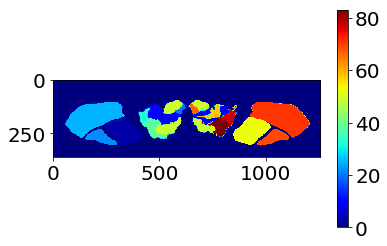

In [62]:
z=400
plt.imshow(atlas_int[:,z,:].T,cmap='jet')
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


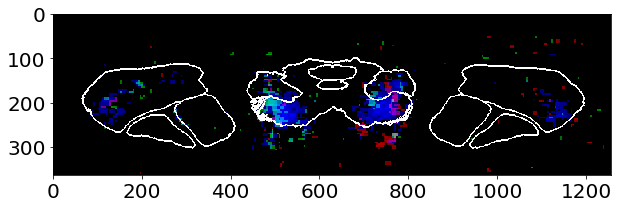

In [56]:
plt.figure(figsize=(10,10))
z=425

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

In [198]:
maps_voxel_high_res

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (0, 0, 390842023984, 140724581770912)
	 Spacing    : (-626.0, -290.0, 0.0, 0.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

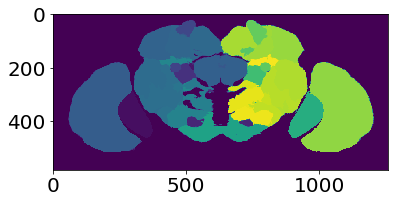

In [161]:
plt.imshow(atlas_int[:,:,200].T)

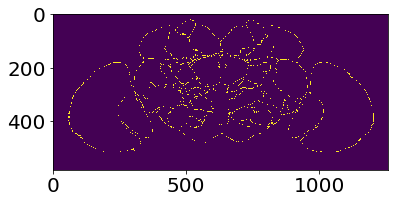

In [163]:
edges = cv2.Canny(atlas_int[:,:,200],1,1)
plt.imshow(edges.T)

In [176]:
edges

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

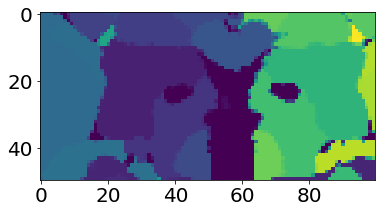

In [144]:
plt.imshow(atlas_int[100:200,50:100,40].T)

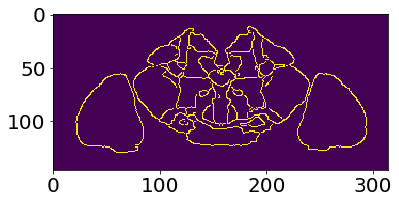

In [148]:
plt.imshow(edges.T)

In [51]:
z = 40
roi_int = 19
empty = np.zeros(atlas_int[:,:,z].shape)
empty[np.where(atlas_int[:,:,z]==roi_int)] = 1
_, atlas_binary = cv2.threshold(empty, 0, 255, cv2.THRESH_BINARY)

# contract and expand to remove spurious single voxels
mask_eroded = binary_erosion(atlas_binary, structure=np.ones((2,2)))
mask_dilated = binary_dilation(mask_eroded, iterations=1)

# get contours
contours, _ = cv2.findContours(mask_dilated.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# draw contours
canvas = np.ones(atlas_binary.shape)
out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
out = np.abs(out-1) #flip 0/1

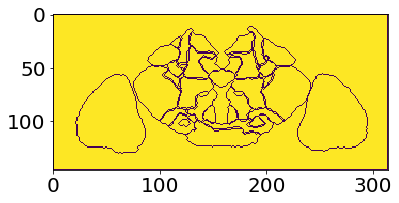

In [99]:
# THIS ONE #
z = 40
atlas_int = atlas.astype('uint8')
atlas_int.shape
roi_ints = np.unique(atlas_int)

canvas = np.ones(atlas_int.shape[:2])
for roi_int in roi_ints:
    empty = np.zeros(atlas_int[:,:,z].shape)
    empty[np.where(atlas_int[:,:,z]==roi_int)] = 1
    _, atlas_binary = cv2.threshold(empty, 0, 255, cv2.THRESH_BINARY)

    # contract and expand to remove spurious single voxels
    mask_eroded = binary_erosion(atlas_binary, structure=np.ones((2,2)))
    mask_dilated = binary_dilation(mask_eroded, iterations=2)

    # get contours
    #cv2.RETR_EXTERNAL or cv2.RETR_TREE
    contours, _ = cv2.findContours(mask_dilated.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # draw contours
    canvas = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
    #out = np.abs(out-1) #flip 0/1
    
plt.imshow(canvas.T)

In [120]:
canvas = np.abs(canvas-1)
mask_dilated = binary_dilation(canvas, iterations=3)
mask_eroded = binary_erosion(mask_dilated, structure=np.ones((2,2)))

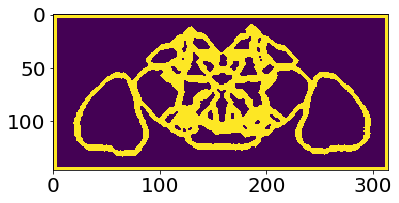

In [121]:
plt.imshow(mask_eroded.T)

In [85]:
canvas.shape

(314, 146, 91)

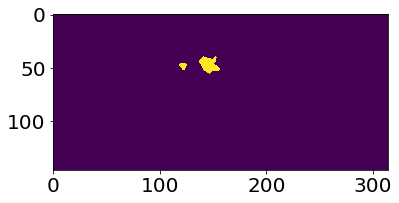

In [48]:
plt.imshow(atlas_binary.T)

In [ ]:
### Make code to
    # take a slice
    # loop over all unique ints
    # for each int binarize and get contour
    
# loop for all z
atlas_int = atlas.astype('uint8')
roi_ints = np.unique(atlas_int)
atlas_contours = []
z = 40

for roi_int in roi_ints:
    # threshold slice
    empty = np.zeros(atlas_int[:,:,z].shape)
    empty[np.where(atlas_int[:,:,z]==roi_int)] = 1
    
    _, atlas_binary = cv2.threshold(empty, 0, 255, cv2.THRESH_BINARY)

    # get contours
    contours, _ = cv2.findContours(atlas_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # draw contours
    canvas = np.ones(atlas_binary.shape)
    out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
    out = np.abs(out-1) #flip 0/1

    #make rgba
    out_ = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
    
    atlas_contours.append(out_)
    
atlas_contours = np.asarray(atlas_contours)

In [12]:
atlas_int = atlas.astype('int')
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

(-0.5, 313.5, 145.5, -0.5)

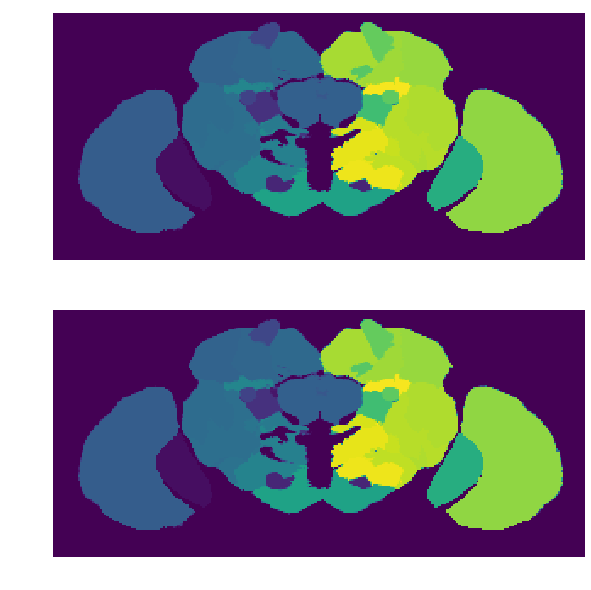

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

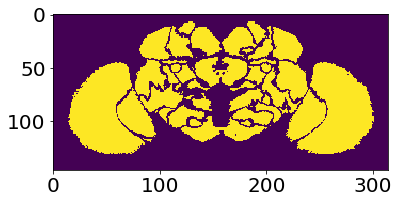

In [13]:
atlas_clean = atlas_clean.astype('uint8')
_, atlas_binary = cv2.threshold(atlas_clean[:,:,50], 0, 255, cv2.THRESH_BINARY)
plt.imshow(atlas_binary.T)

In [14]:
#cv2.RETR_TREE
contours, _ = cv2.findContours(atlas_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [15]:
canvas = np.ones(atlas_binary.shape)
out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
out = np.abs(out-1) #flip 0/1

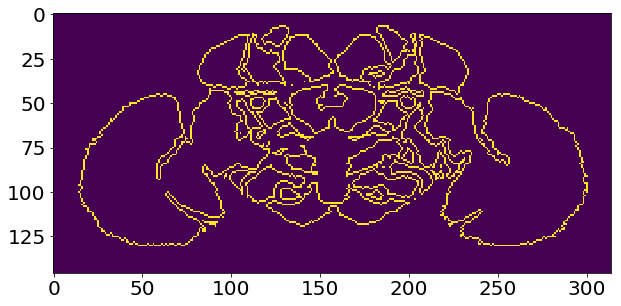

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(out.T)

In [17]:
out_ = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

In [18]:
out_.shape

(314, 146, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 313.5, 145.5, -0.5)

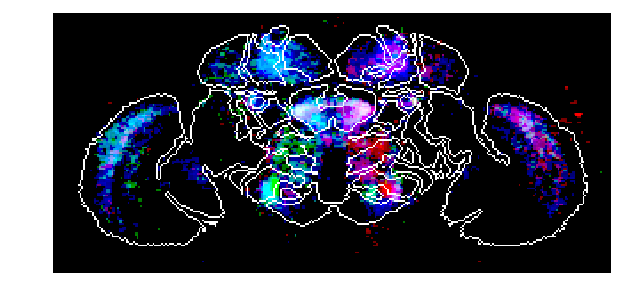

In [19]:
z=50
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*20,0,1))
plt.imshow(np.swapaxes(out_,0,1))
plt.axis('off')

In [20]:
# loop for all z
atlas_clean = atlas_clean.astype('uint8')
atlas_contours = []

for z in range(91):
    # threshold slice
    _, atlas_binary = cv2.threshold(atlas_clean[:,:,z], 0, 255, cv2.THRESH_BINARY)

    # get contours
    contours, _ = cv2.findContours(atlas_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # draw contours
    canvas = np.ones(atlas_binary.shape)
    out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
    out = np.abs(out-1) #flip 0/1

    #make rgba
    out_ = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
    
    atlas_contours.append(out_)
    
atlas_contours = np.asarray(atlas_contours)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 313.5, 145.5, -0.5)

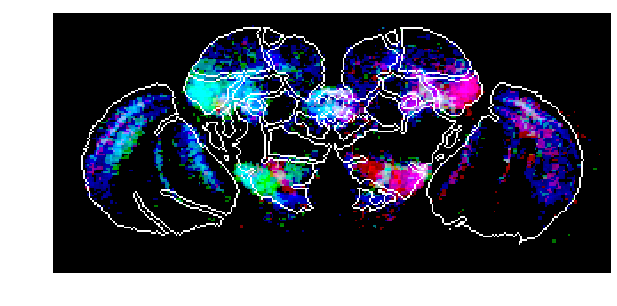

In [21]:
z=60
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*20,0,1))
plt.imshow(np.swapaxes(atlas_contours[z,...],0,1))
plt.axis('off')

# print roi names on images

In [36]:

# have manually swapped R and Ls
rois = {26: 'FB',
4: 'NO',
5: 'BU_L',
54: 'BU_R',
8: 'LAL_L',
56: 'LAL_R',
31: 'PVLP_L',
76: 'PVLP_R',
6: 'PB',
23: 'EB',
13: 'VES_L',  
40: 'EPA_L',
35: 'GOR_L',
11: 'AMMC_L',
60: 'VES_R', 
85: 'EPA_R',
80: 'GOR_R',
58: 'AMMC_R',
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_L',
75: 'AVLP_R',
24: 'AL_L',
70: 'AL_R',
64: 'MB_PED_R',
65: 'MB_VL_R',
66: 'MB_ML_R',
81: 'MB_CA_R',
17: 'MB_PED_L',
18: 'MB_VL_L',
19: 'MB_ML_L',
36: 'MB_CA_L',
32: 'IVLP_L',
77: 'IVLP_R',
10: 'CAN_L',
20: 'FLA_L',
57: 'CAN_R',
67: 'FLA_R',
27: 'SLP_L',
29: 'SMP_L',
33: 'PLP_L',
7: 'LH_L',
38: 'IPS_L',
37: 'SPS_L',
16: 'CRE_L',
39: 'SCL_L',
12: 'ICL_L',
15: 'ATL_L',
14: 'IB_L',
28: 'SIP_L',#####
72: 'SLP_R',   
74: 'SMP_R',
78: 'PLP_R',
55: 'LH_R',
83: 'IPS_R',
82: 'SPS_R',
63: 'CRE_R',
84: 'SCL_R',  
59: 'ICL_R',
62: 'ATL_R',
61: 'IB_R',
73: 'SIP_R',
25: 'MED_L',
3: 'LO_L',
22: 'LP_L',
34: 'AOTU_L',
71: 'MED_R',
53: 'LO_R',
69: 'LP_R',
79: 'AOTU_R'}

In [46]:
#########################
### find ROI centrois ###
#########################

all_roi_labels = []
for z in range(91):
    roi_labels = {}
    for roi in np.unique(atlas_clean[:,:,z]):
        if roi == 0:
            continue
        mask = np.zeros((314,146))
        mask[np.where(atlas_clean[:,:,z]==roi)]=1
        mask = mask.astype('uint8')
        M = cv2.moments(mask)
        cY = int(M["m10"] / M["m00"])
        cX = int(M["m01"] / M["m00"])
        roi_labels[roi] = (cX,cY)
    all_roi_labels.append(roi_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


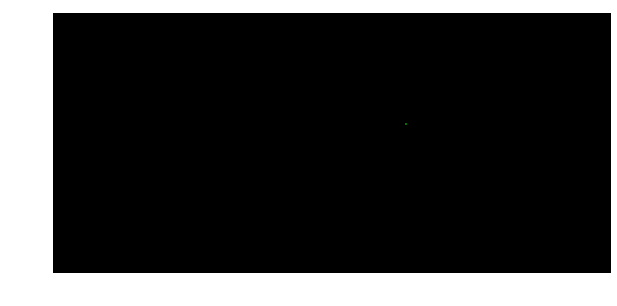

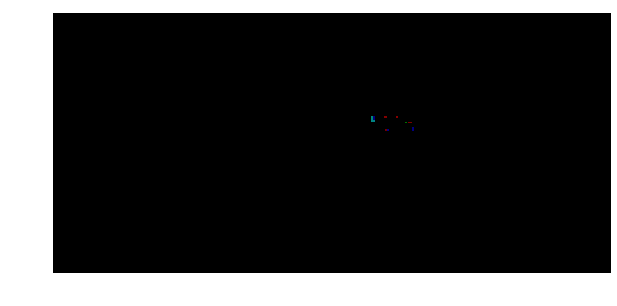

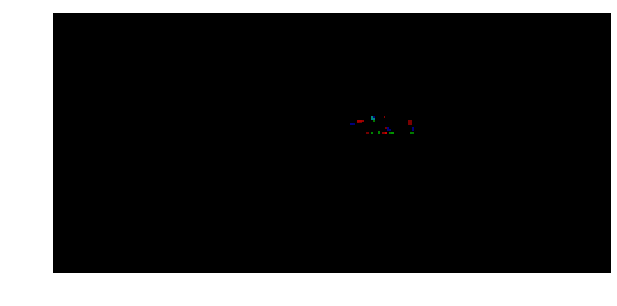

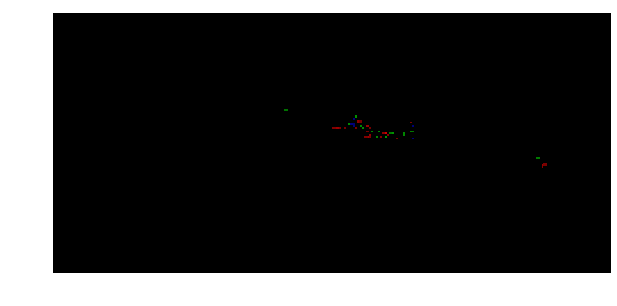

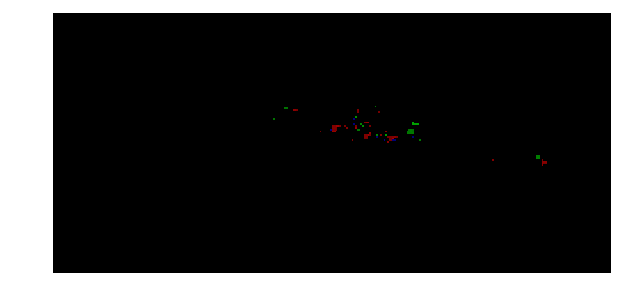

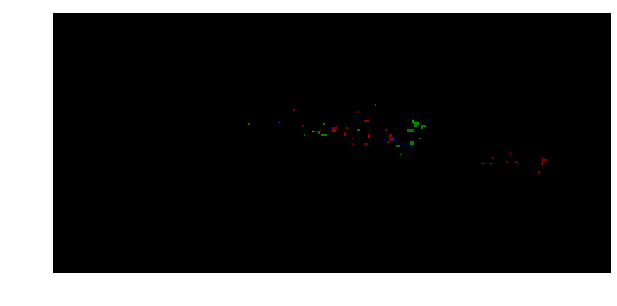

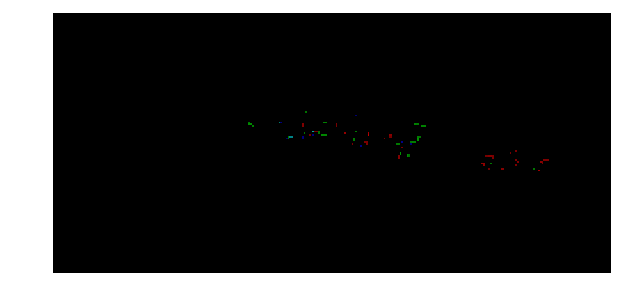

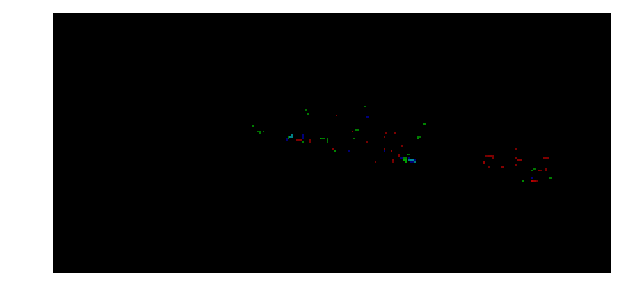

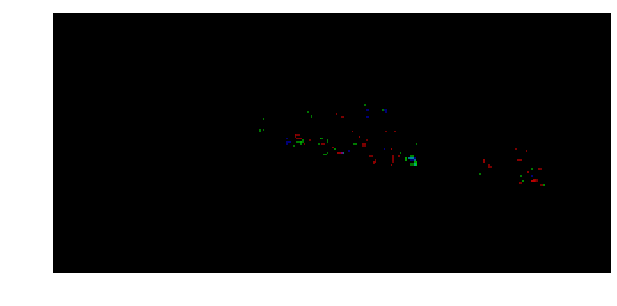

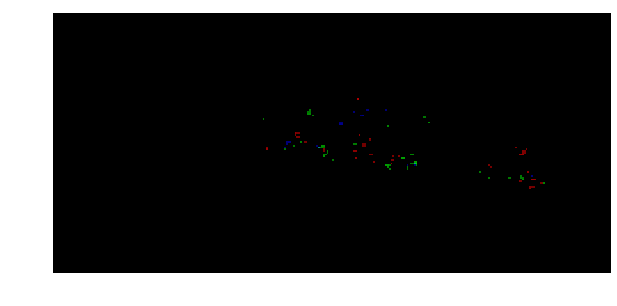

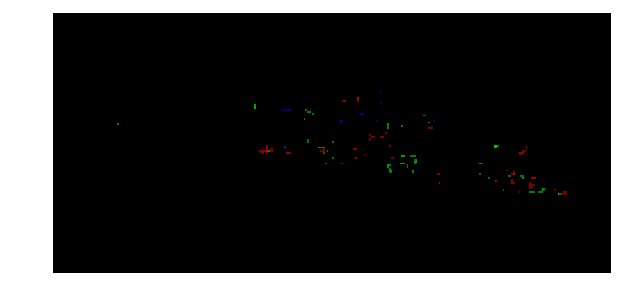

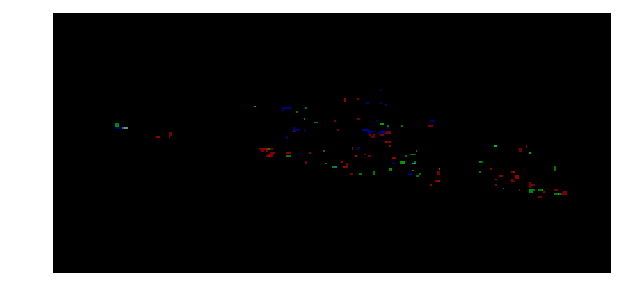

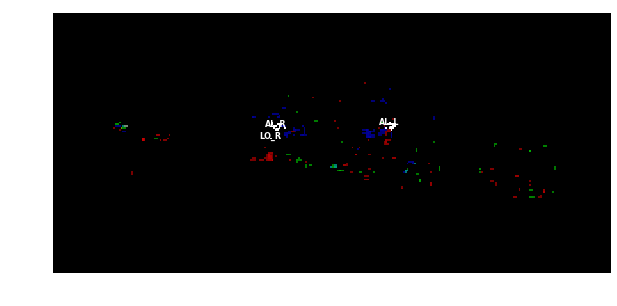

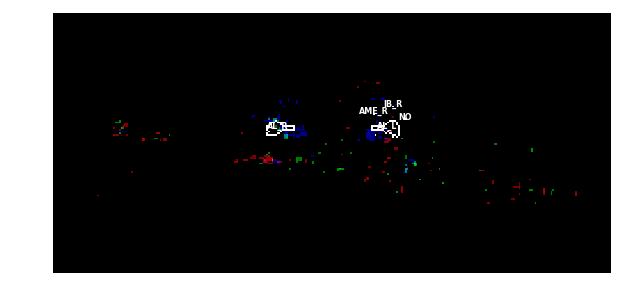

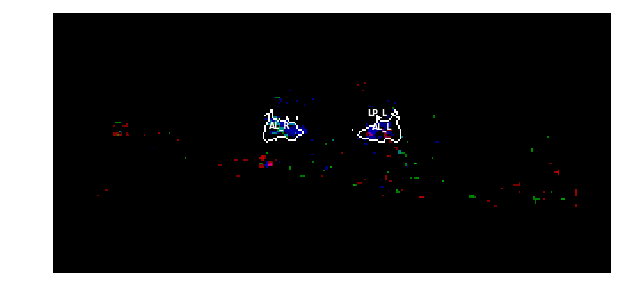

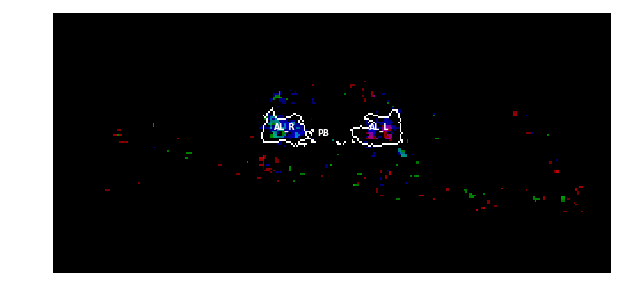

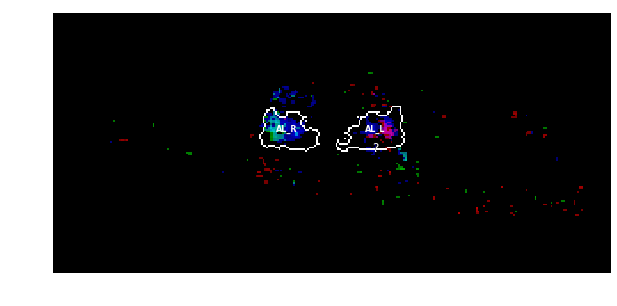

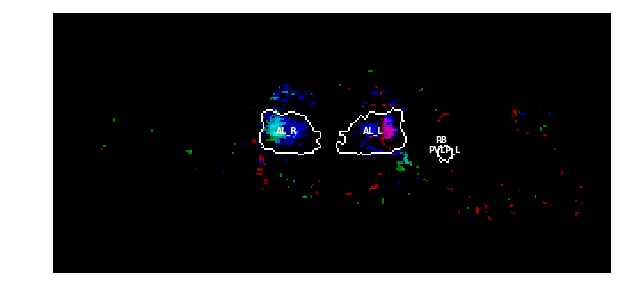

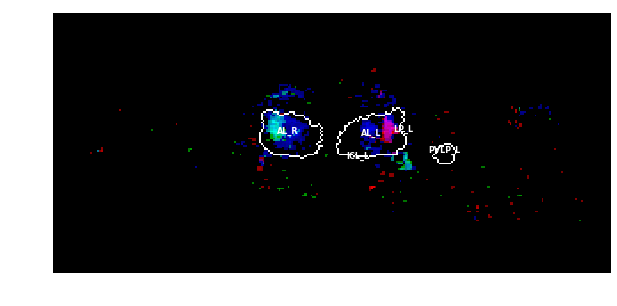

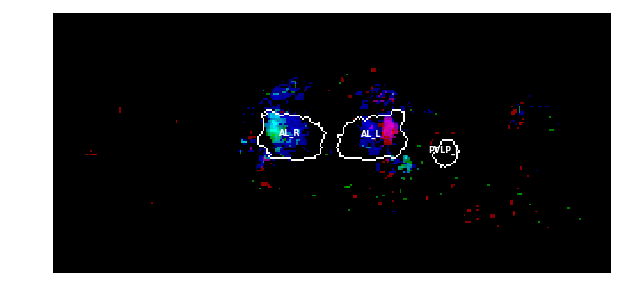

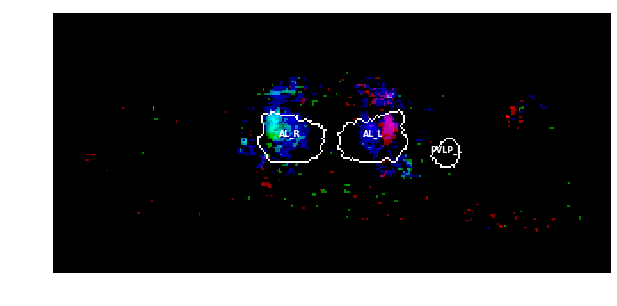

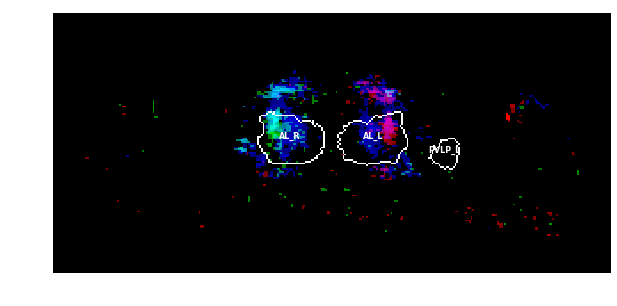

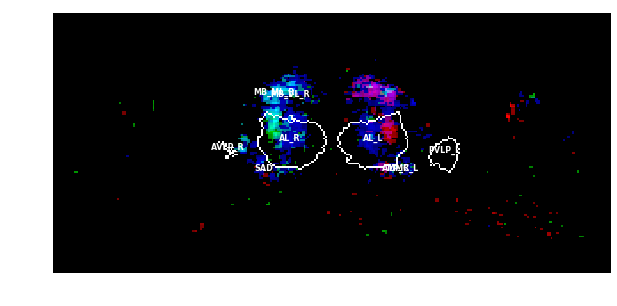

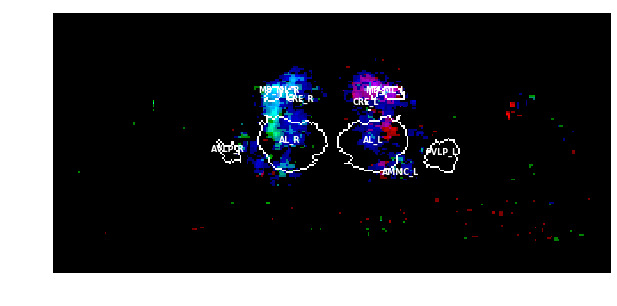

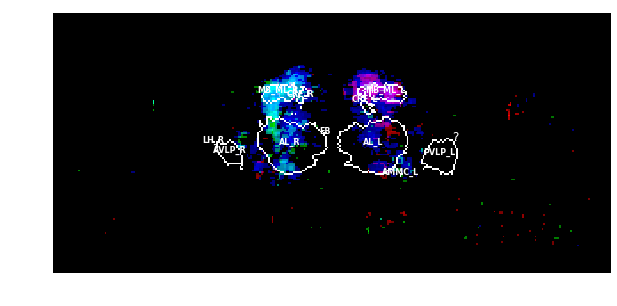

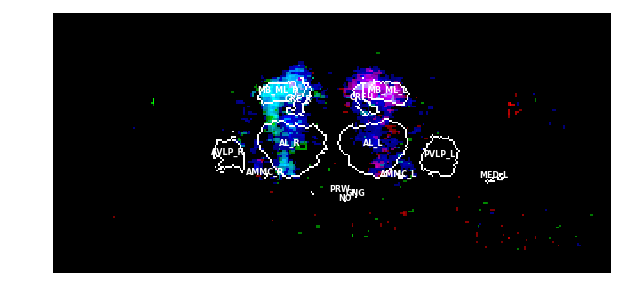

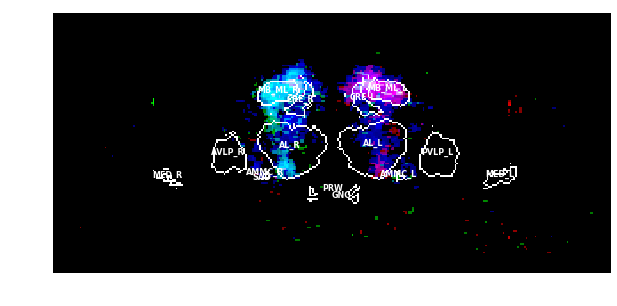

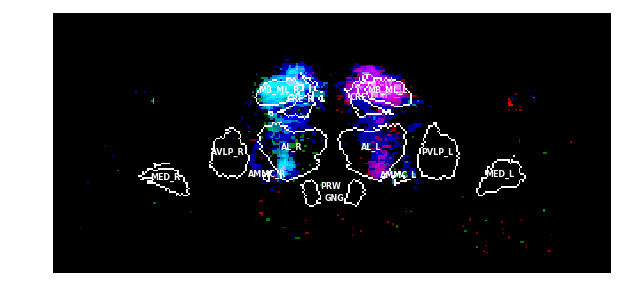

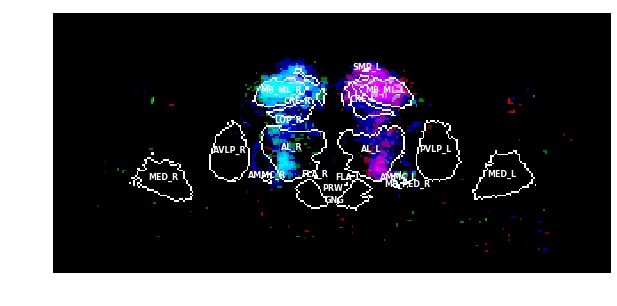

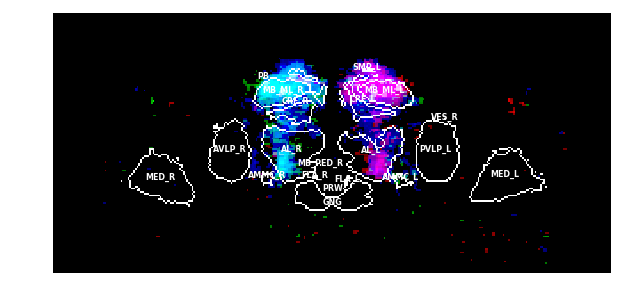

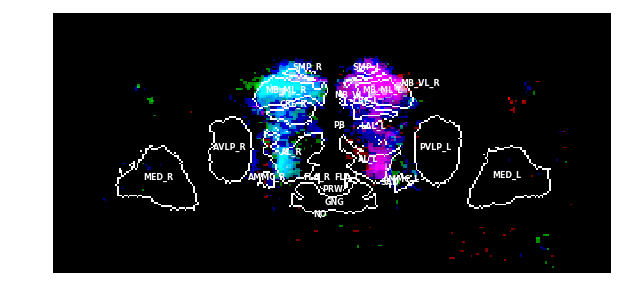

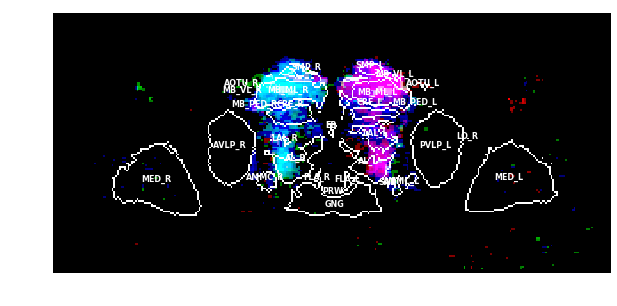

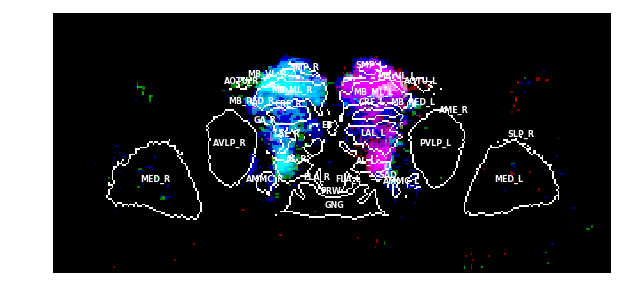

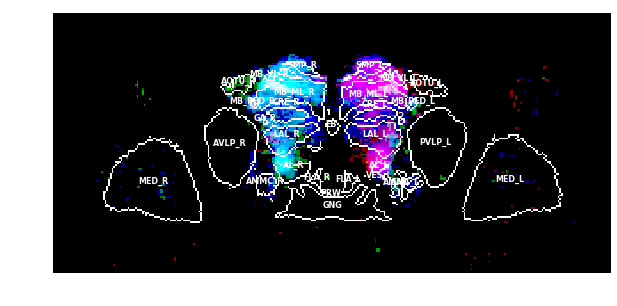

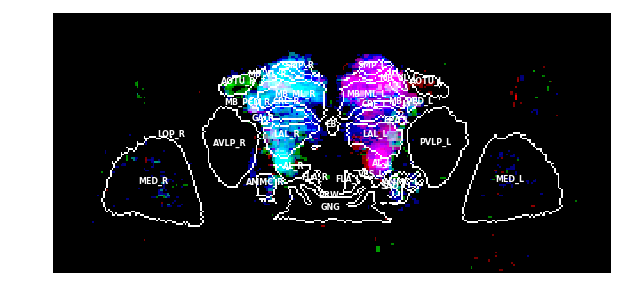

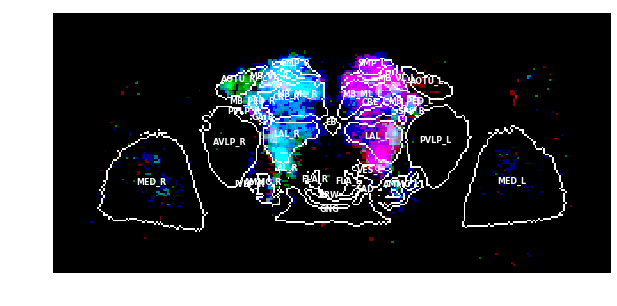

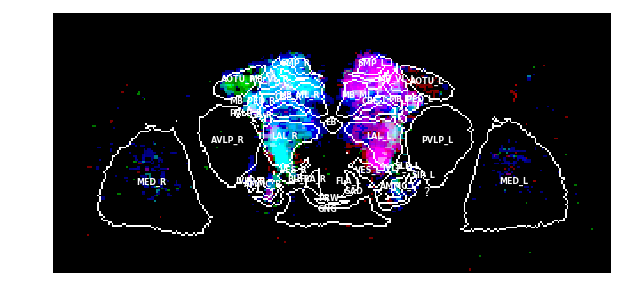

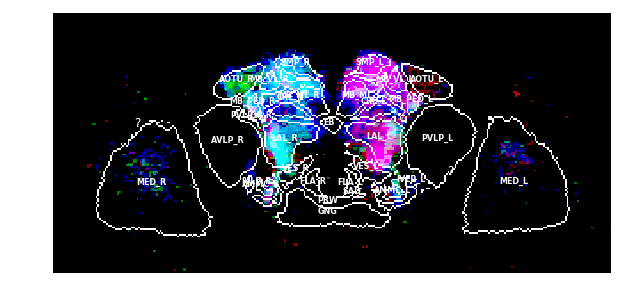

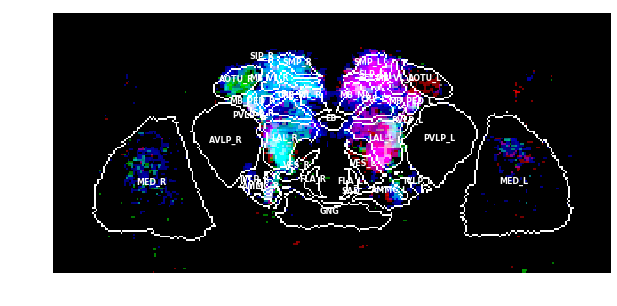

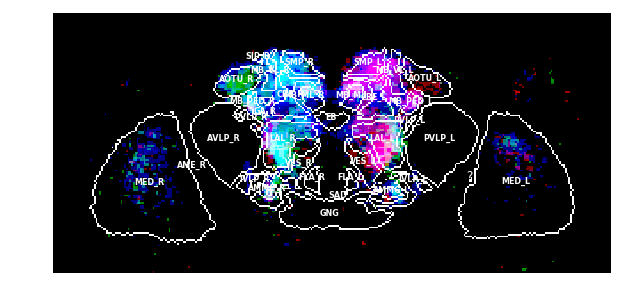

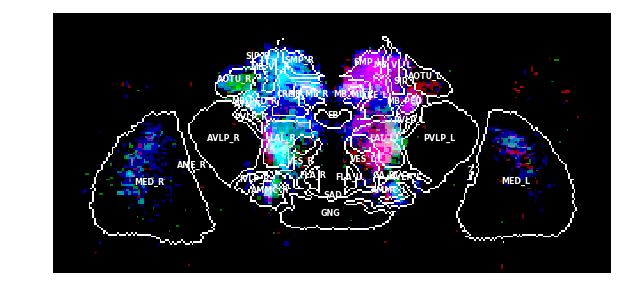

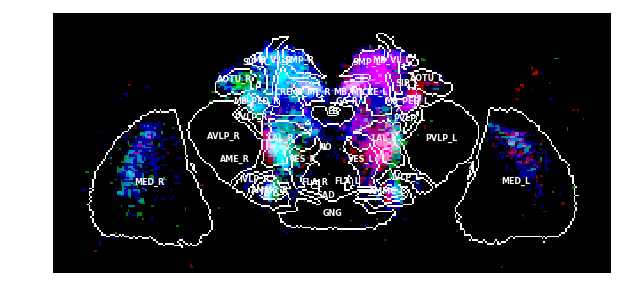

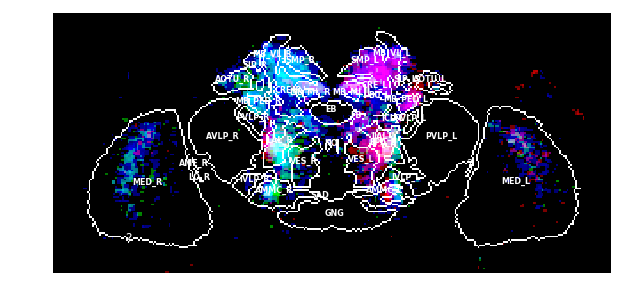

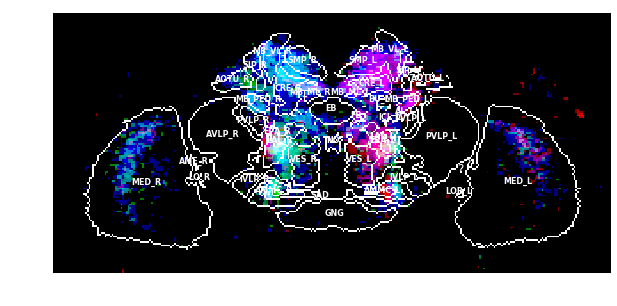

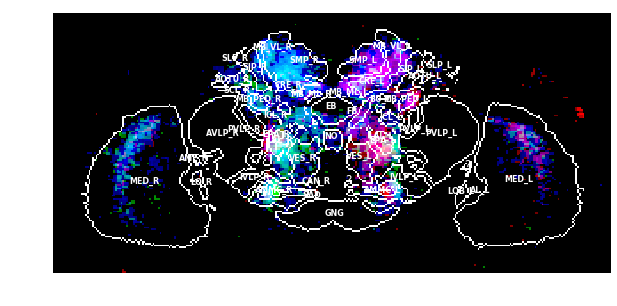

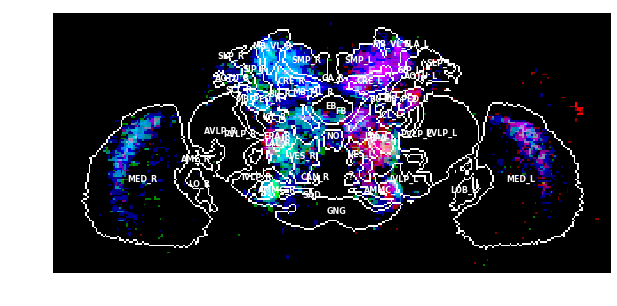

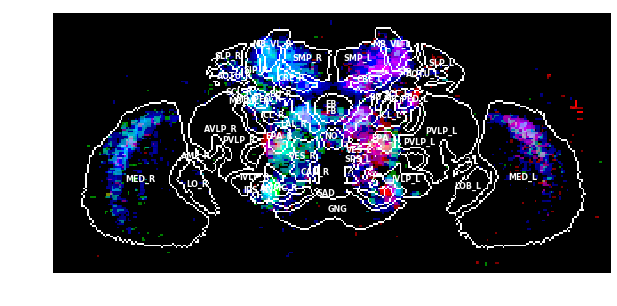

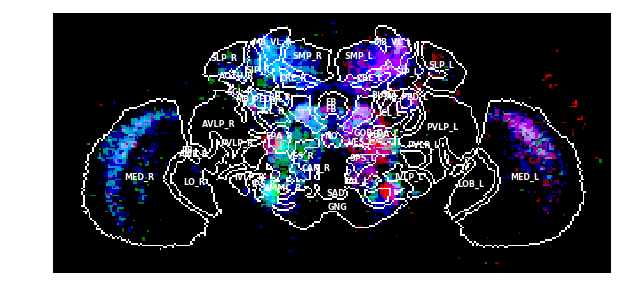

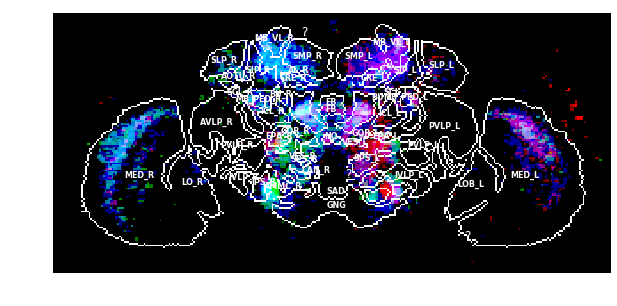

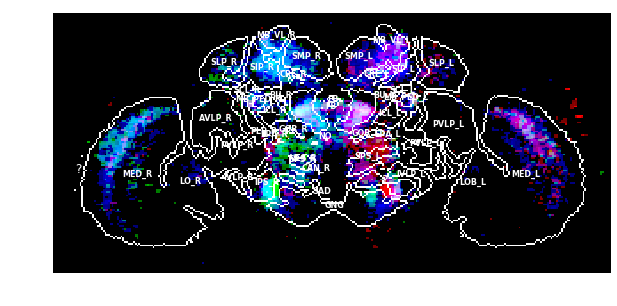

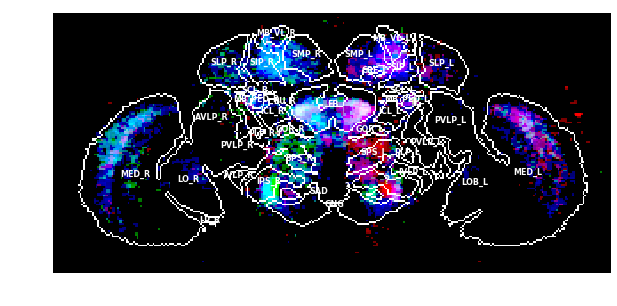

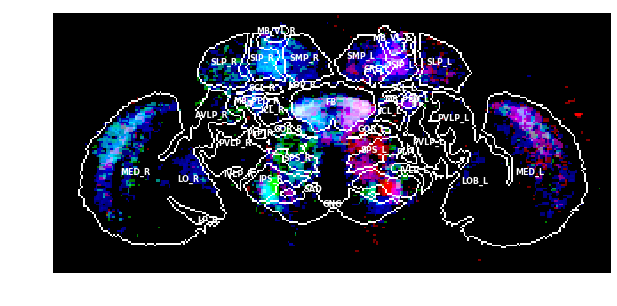

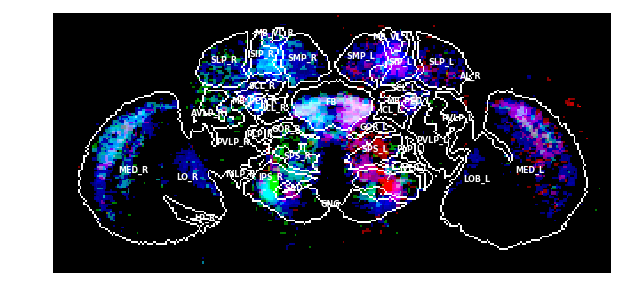

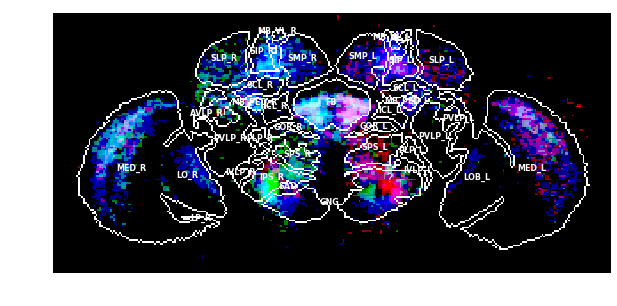

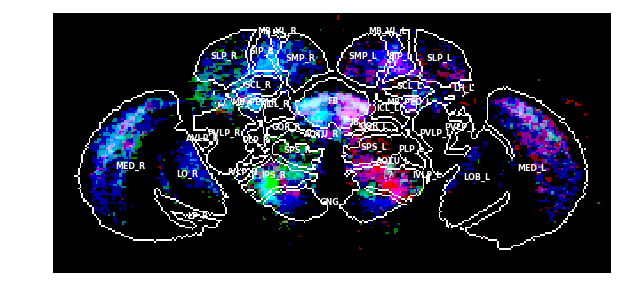

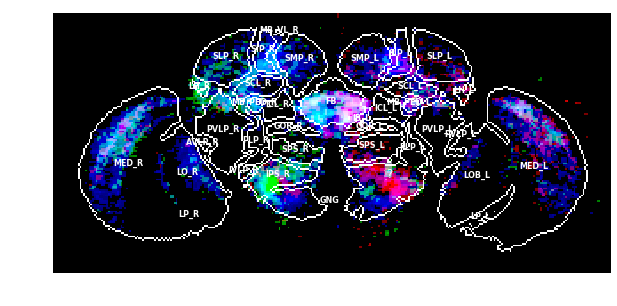

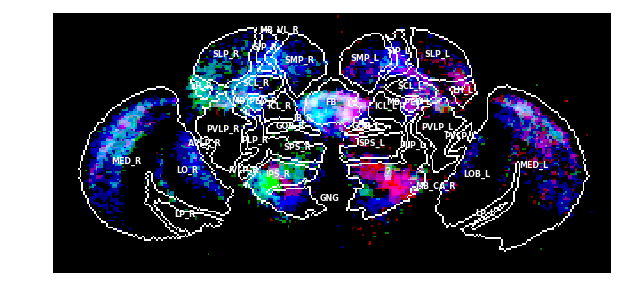

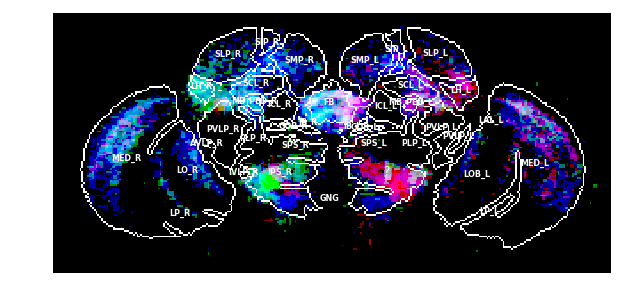

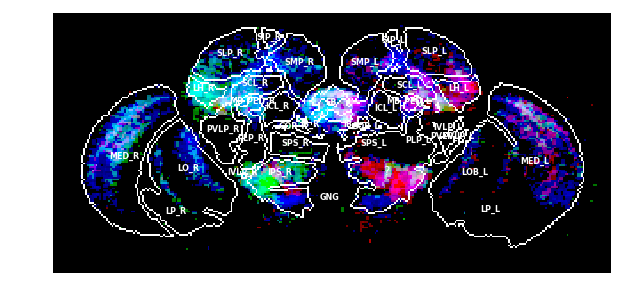

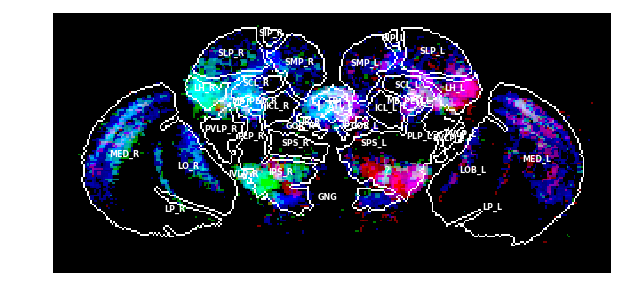

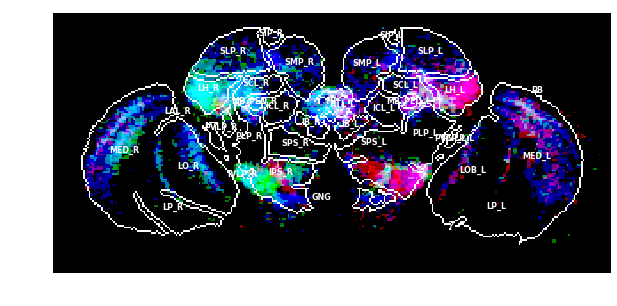

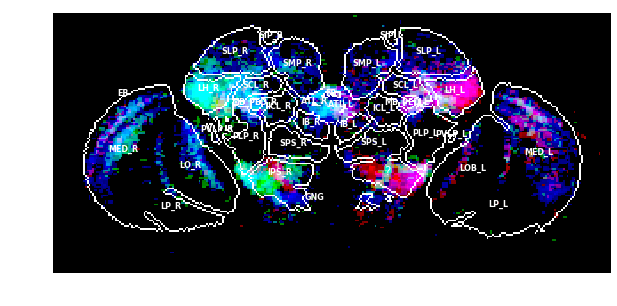

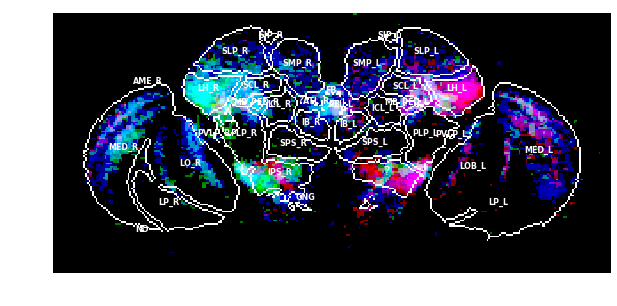

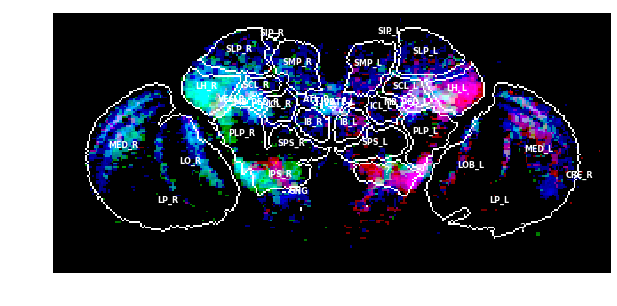

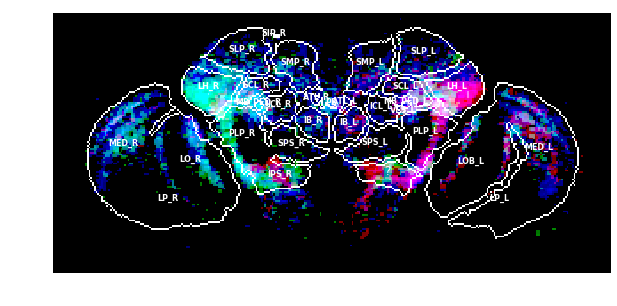

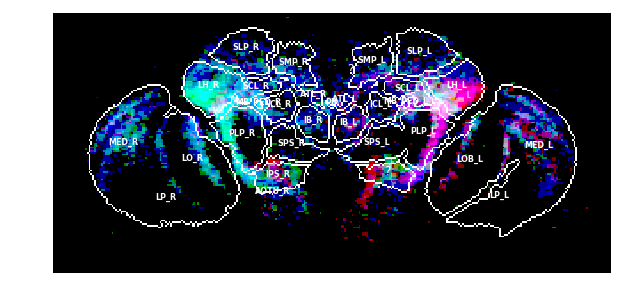

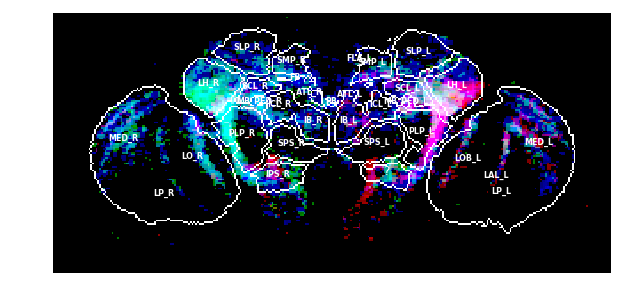

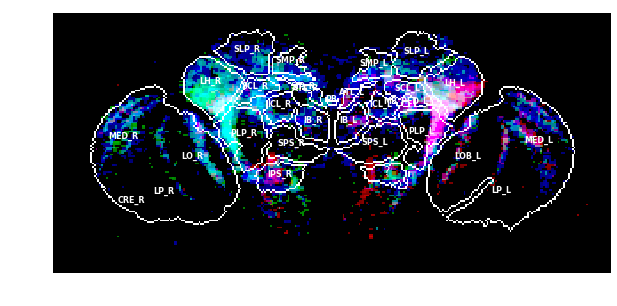

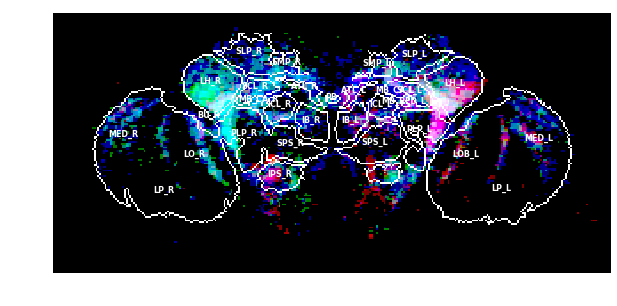

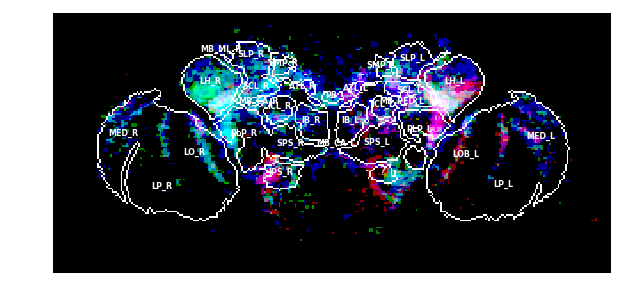

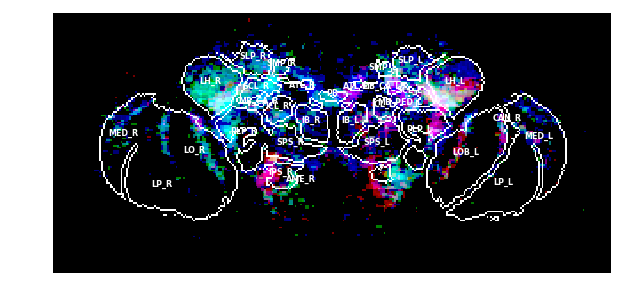

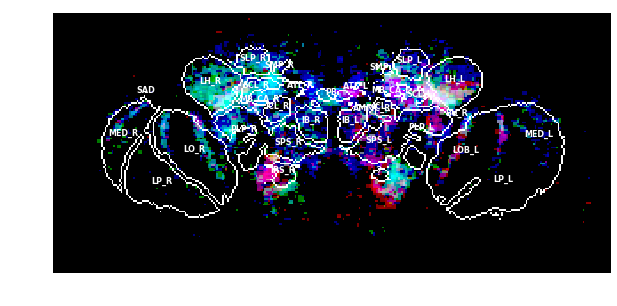

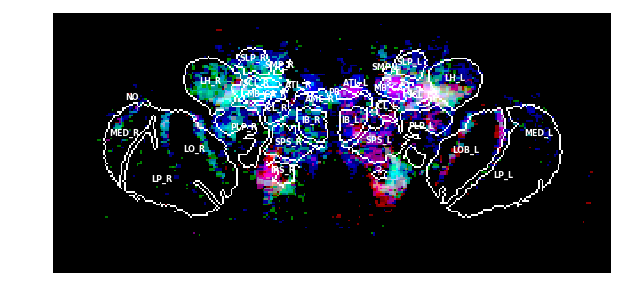

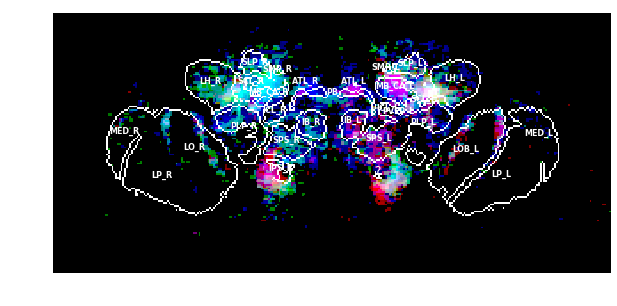

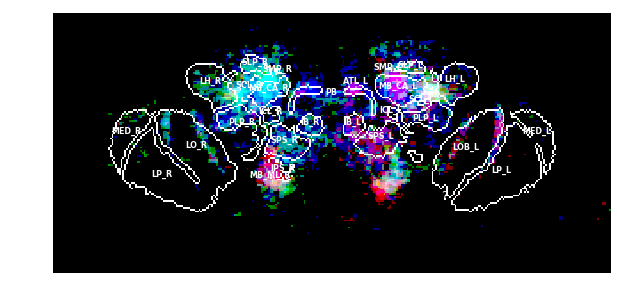

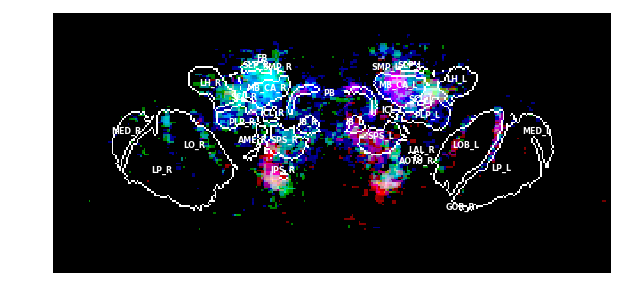

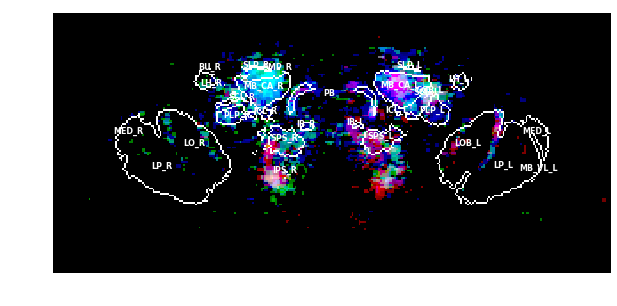

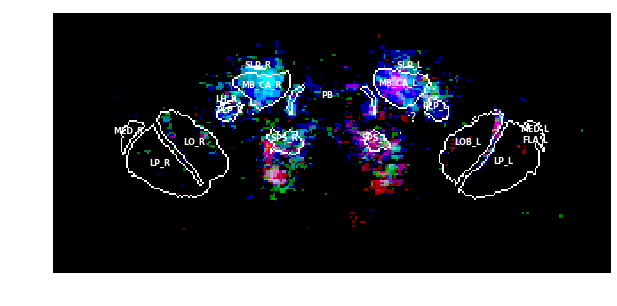

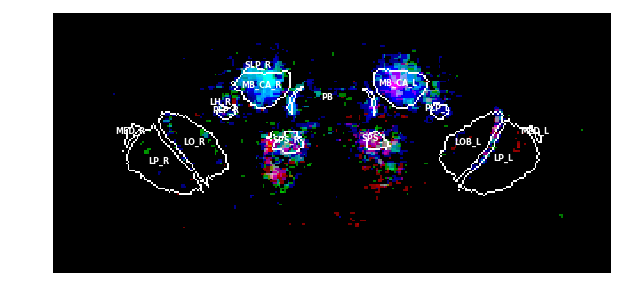

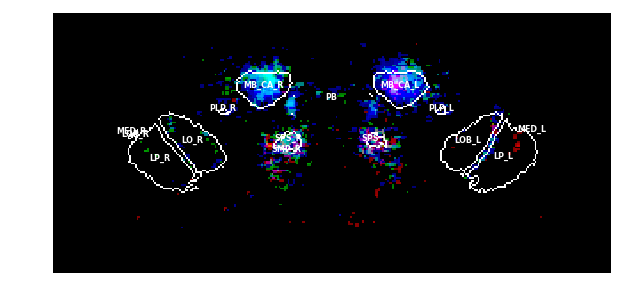

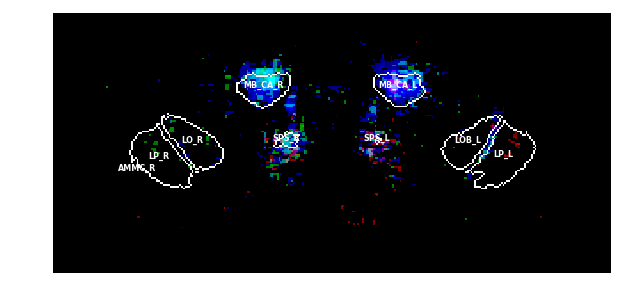

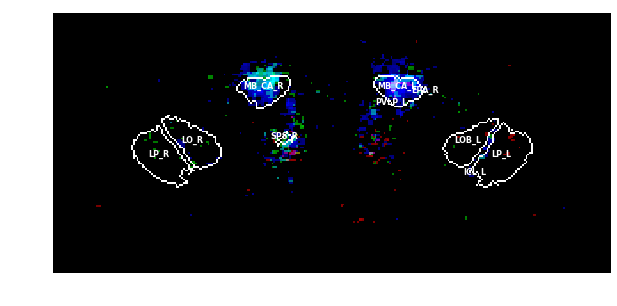

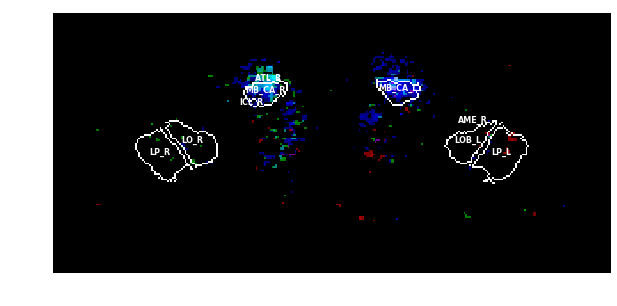

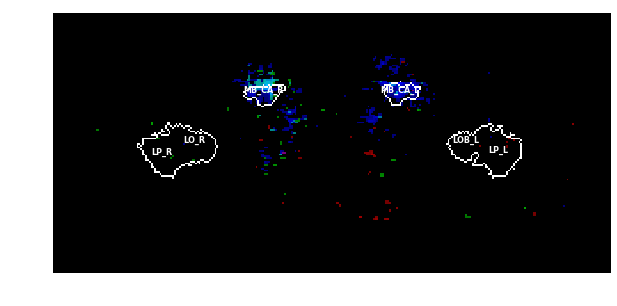

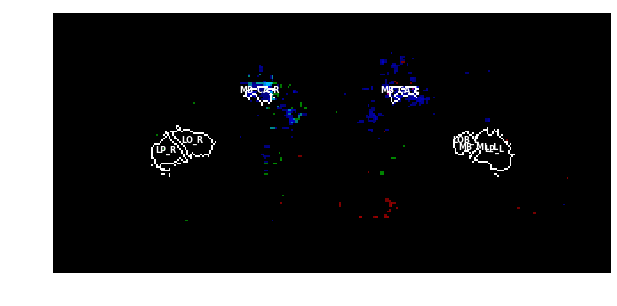

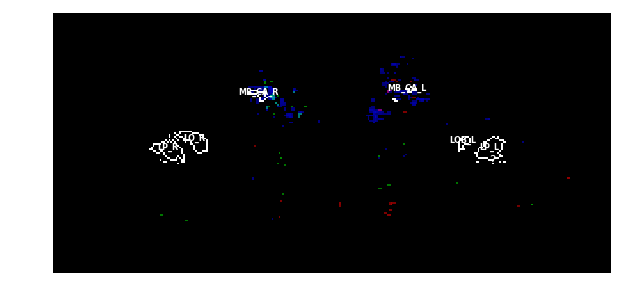

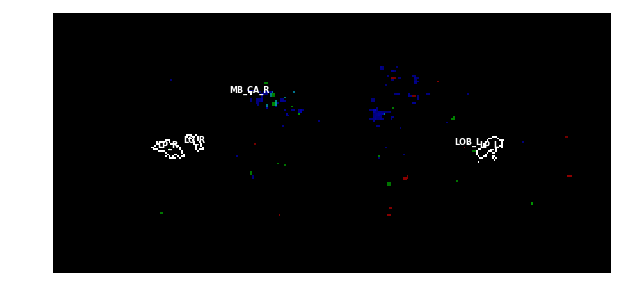

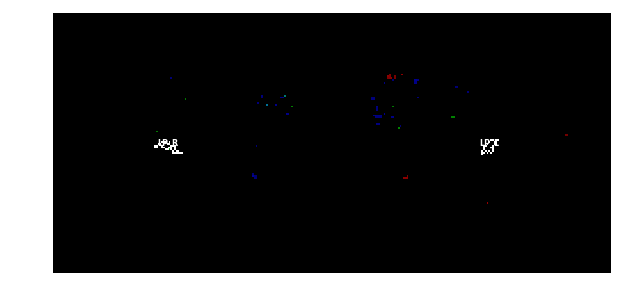

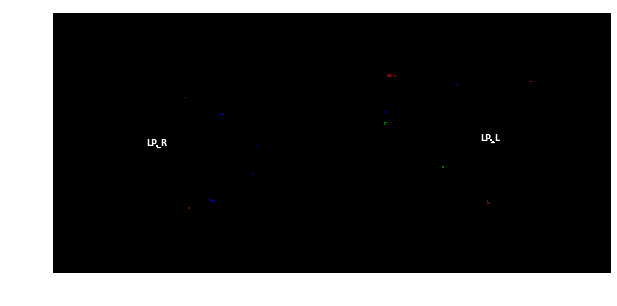

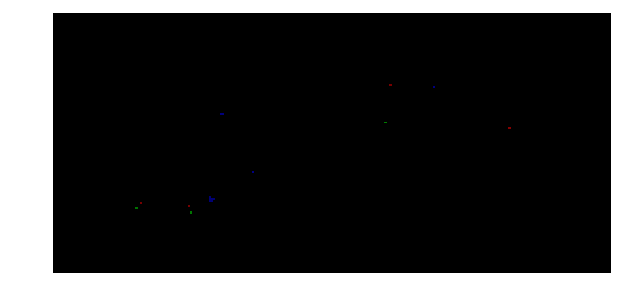

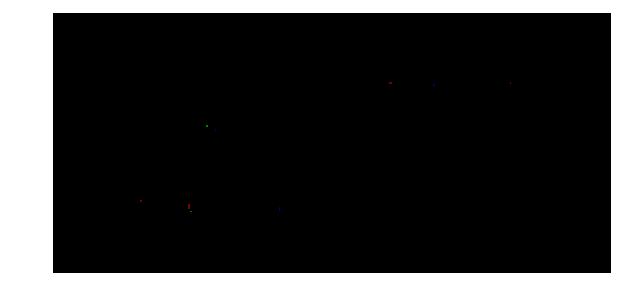

In [56]:
for z in range(91):
    plt.figure(figsize=(10,10))
    plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*20,0,1))
    plt.imshow(np.swapaxes(atlas_contours[z,...],0,1))
    plt.axis('off')

    for roi in all_roi_labels[z]:
        try:
            plt.text(x=all_roi_labels[z][roi][0],
                     y=all_roi_labels[z][roi][1],
                     s=rois[roi],fontsize=8,ha='center',color='w',
                     fontweight='heavy')
        except KeyError:
            plt.text(x=all_roi_labels[z][roi][0],
                     y=all_roi_labels[z][roi][1],
                     s='?',fontsize=12,ha='center',color='w')
            
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210629_corr_video'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    label = format(z, '02d')
    fname = os.path.join(save_path, f'{label}')
    plt.savefig(fname,dpi=100,bbox_inches='tight')

In [55]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210629_corr_video'
os.mkdir(save_path)

# Updated Video

In [22]:
atlas.shape

(1256, 584, 363)

In [43]:
#########################
### find ROI centrois ###
#########################

all_roi_labels = []
for z in range(91):
    roi_labels = {}
    for roi in np.unique(atlas[:,:,z]):
        vox_cnt = len(np.where(atlas[:,:,40]==roi)[0])
        if vox_cnt < 40:
            continue
        if roi == 0:
            continue
        mask = np.zeros((314,146))
        mask[np.where(atlas[:,:,z]==roi)]=1
        mask = mask.astype('uint8')
        M = cv2.moments(mask)
        cY = int(M["m10"] / M["m00"])
        cX = int(M["m01"] / M["m00"])
        roi_labels[roi] = (cX,cY)
    all_roi_labels.append(roi_labels)

In [117]:
#########################
### find ROI centrois ###
#########################

all_roi_labels = []
roi_labels = {}
for roi in np.unique(atlas_int[:,z,:]):
#     vox_cnt = len(np.where(atlas_int[:,z,:]==roi)[0])
#     if vox_cnt < 40:
#         continue
    if roi == 0:
        continue
    mask = np.zeros((1256,363))
    mask[np.where(atlas[:,z,:]==roi)]=1
    mask = mask.astype('uint8')
    M = cv2.moments(mask)
    cY = int(M["m10"] / M["m00"])
    cX = int(M["m01"] / M["m00"])
    roi_labels[roi] = (cX,cY)
all_roi_labels.append(roi_labels)

In [37]:
##########################
### find ROI centroids ###
##########################

all_roi_labels = []
for z in range(584):
    roi_labels = {}
    for roi in np.unique(atlas_int[:,z,:]):
        vox_cnt = len(np.where(atlas_int[:,z,:]==roi)[0])
        if vox_cnt < 1000:
            continue
        if roi == 0:
            continue
        mask = np.zeros((1256,363))
        mask[np.where(atlas[:,z,:]==roi)]=1
        mask = mask.astype('uint8')
        M = cv2.moments(mask)
        cY = int(M["m10"] / M["m00"])
        cX = int(M["m01"] / M["m00"])
        roi_labels[roi] = (cX,cY)
    all_roi_labels.append(roi_labels)

In [27]:
### MAKE ALPHA ###
signals = maps_voxel_high_res.numpy()
alpha = np.ones((1256, 584, 363))
alpha[np.where(np.sum(signals,axis=-1)==0)]=0
signals_alpha = np.concatenate((signals,alpha[..., np.newaxis]),axis=-1)

In [26]:
maps_voxel_high_res.shape

(1256, 584, 363, 3)

In [ ]:
signals_alpha.shape

In [116]:
atlas_int.shape

(1256, 584, 363)

In [28]:
highres_anat['warpedmovout'].shape

(1256, 584, 363)

In [32]:
list(range(0,10,2))

[0, 2, 4, 6, 8]

360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


362


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


364


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


368


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


370


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


372


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


378


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


380


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


388


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


390


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


392


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


396


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


408


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


410


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


420


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


424


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


430


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


438


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


446


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


448


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


460


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


464


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


468


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


470


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


472


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


490


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


502


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


510


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


516


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


520


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


530


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


534


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


538


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


540


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


548


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


556


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


558


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


560


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


570


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


580


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


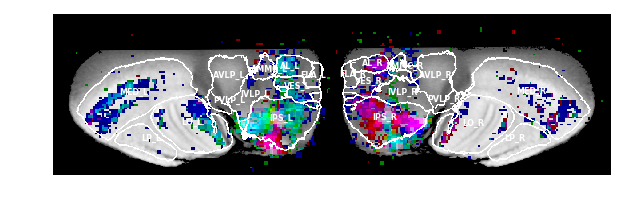

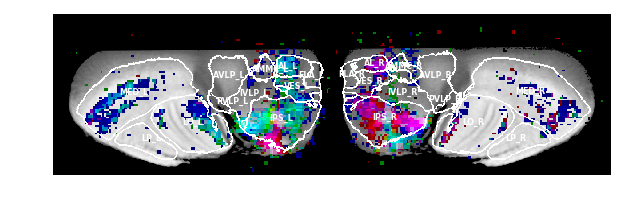

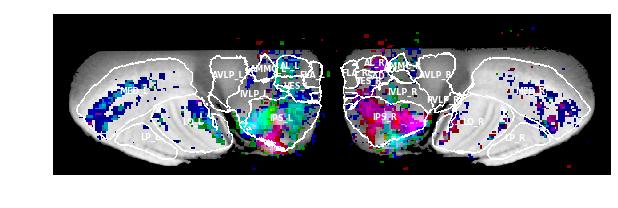

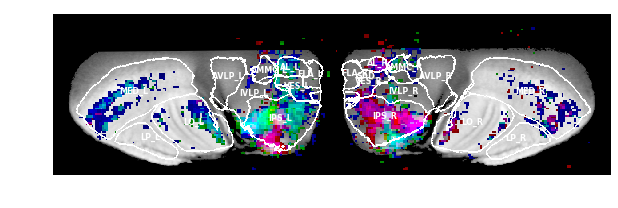

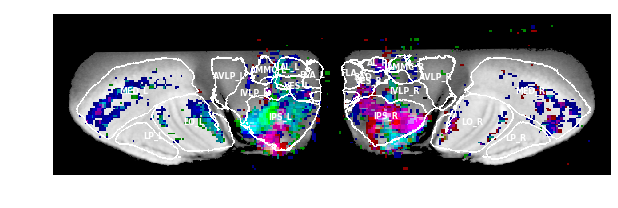

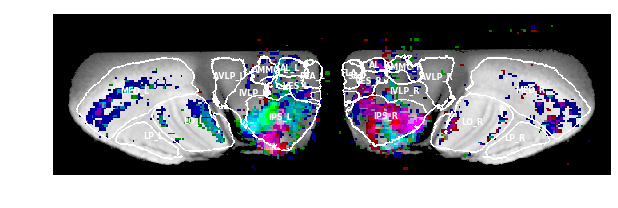

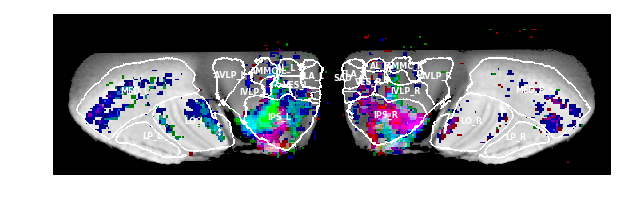

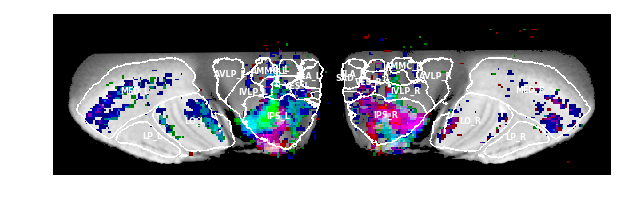

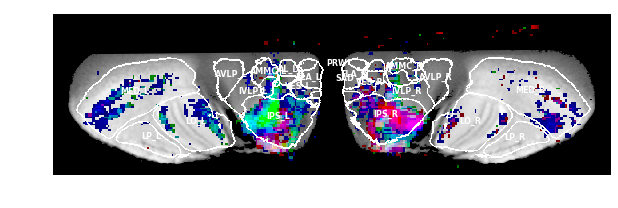

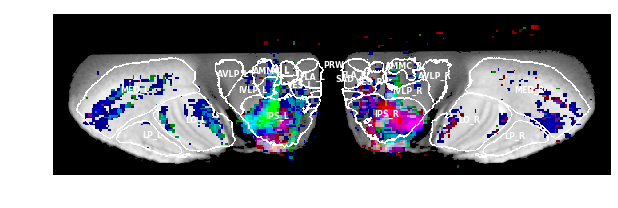

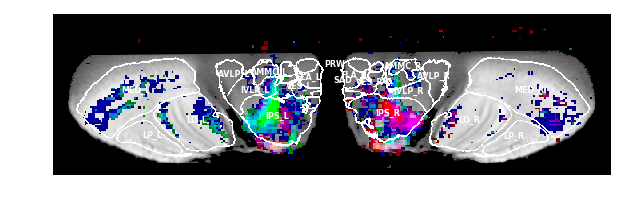

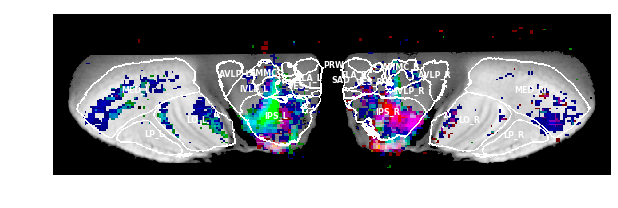

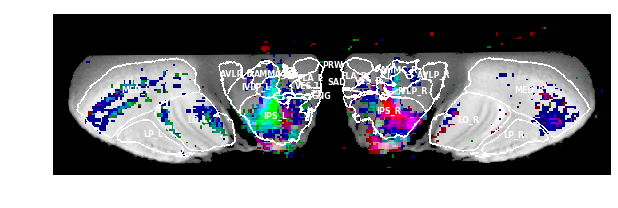

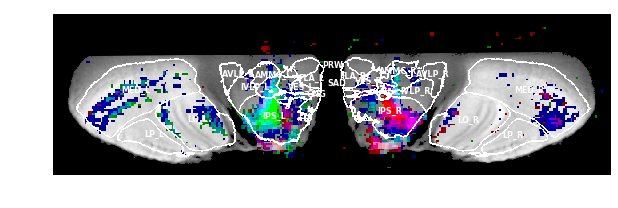

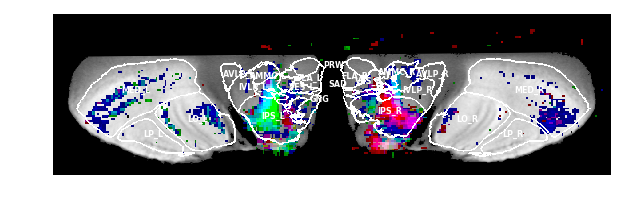

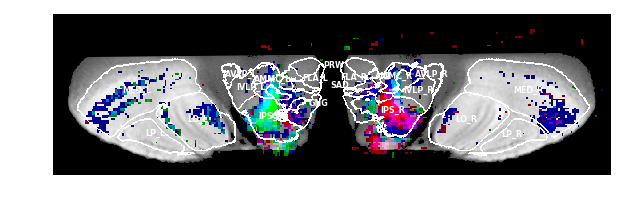

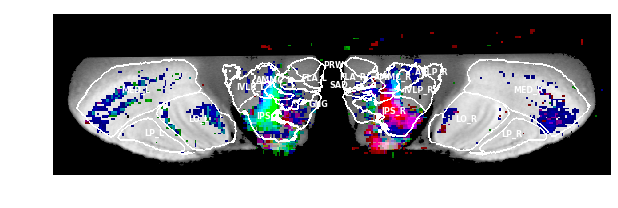

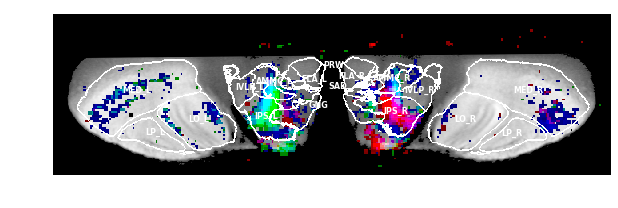

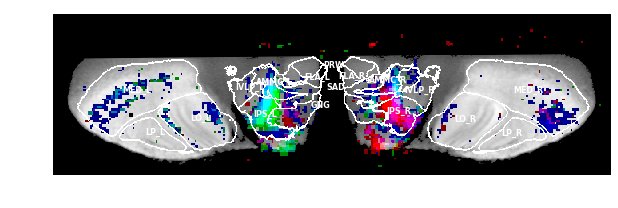

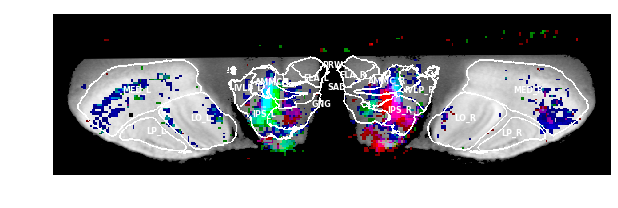

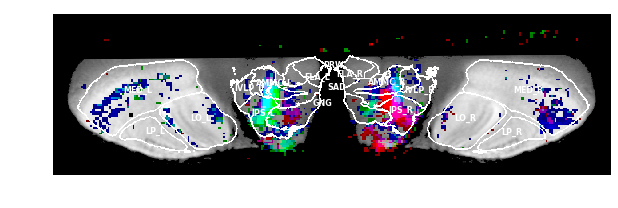

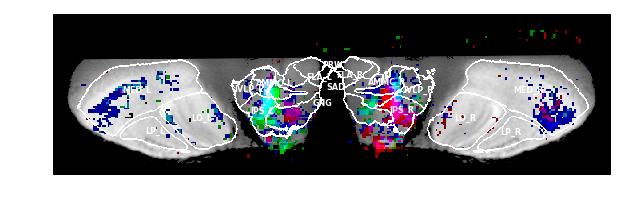

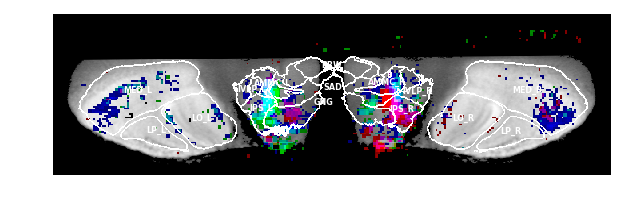

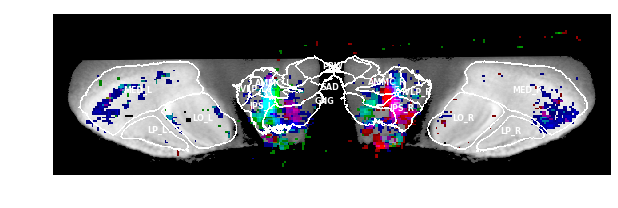

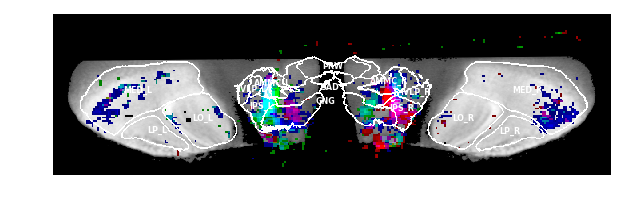

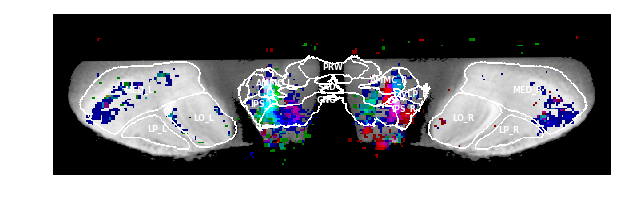

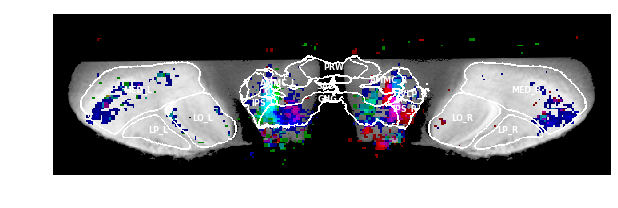

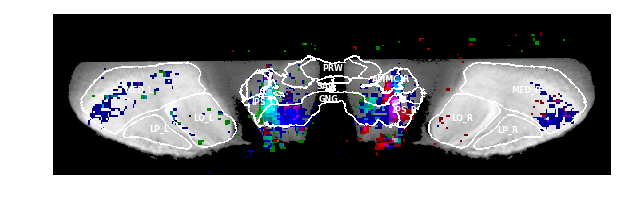

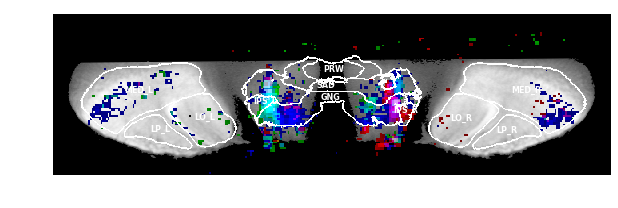

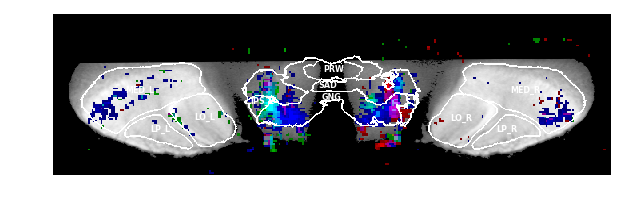

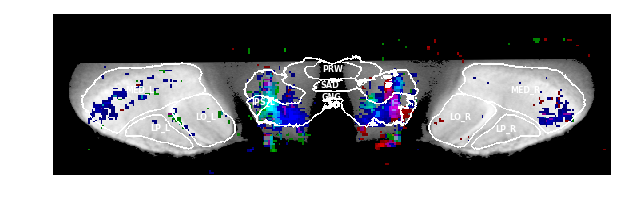

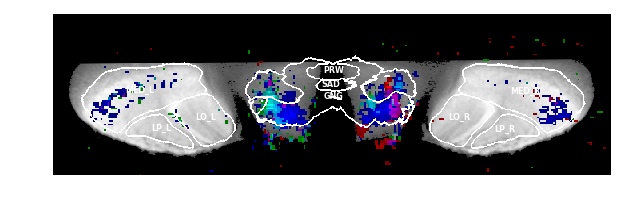

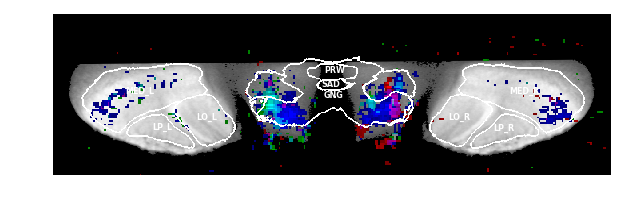

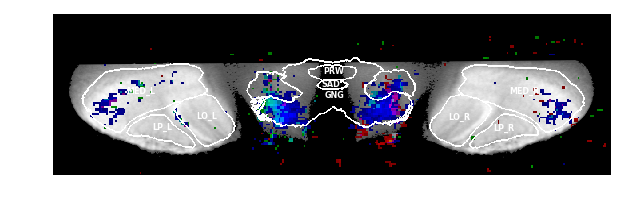

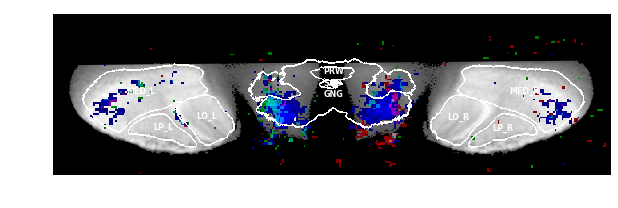

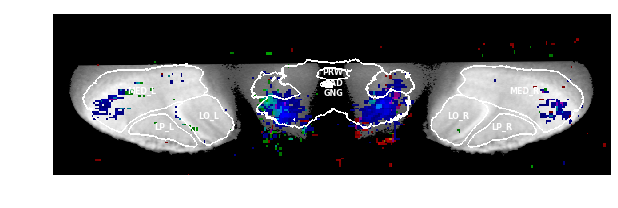

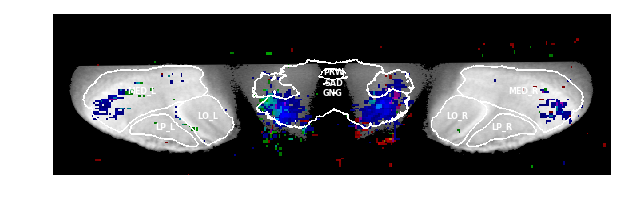

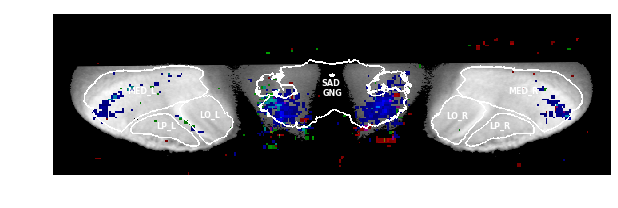

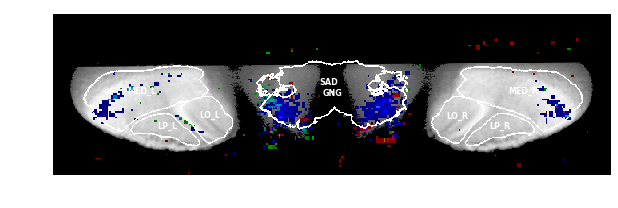

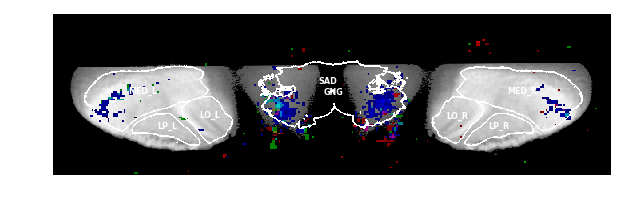

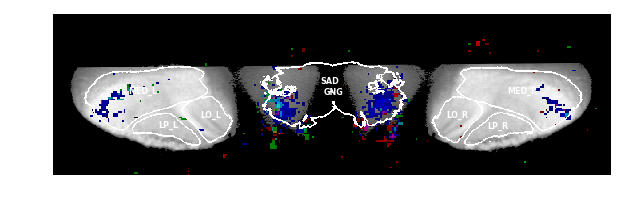

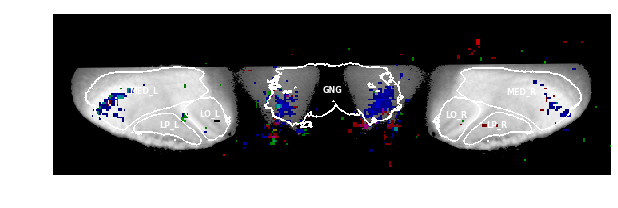

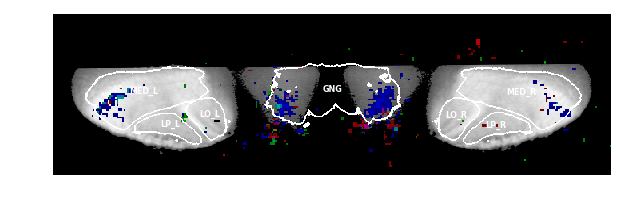

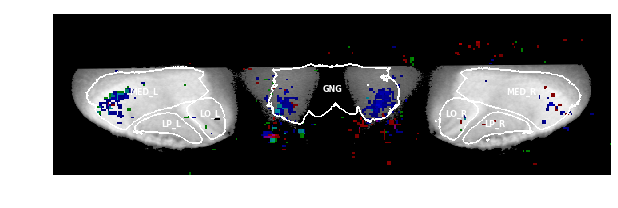

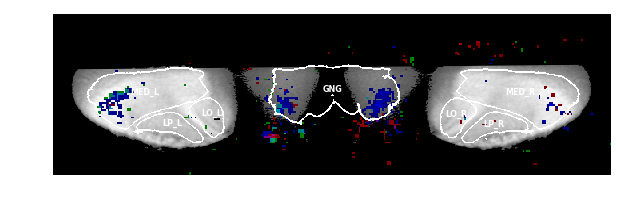

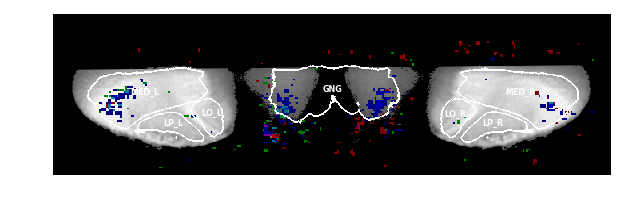

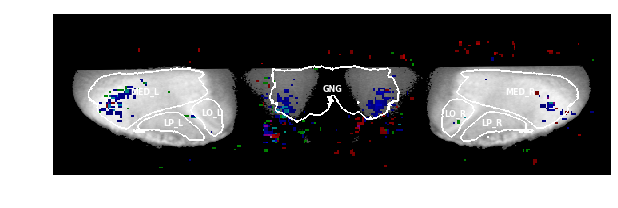

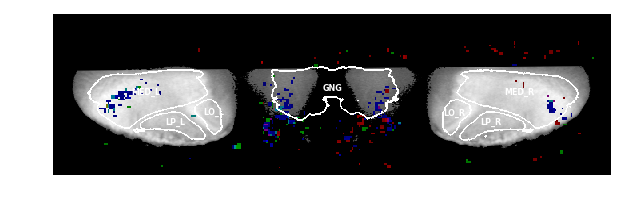

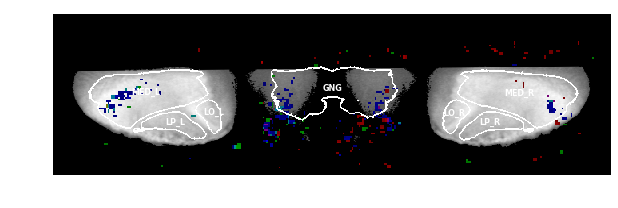

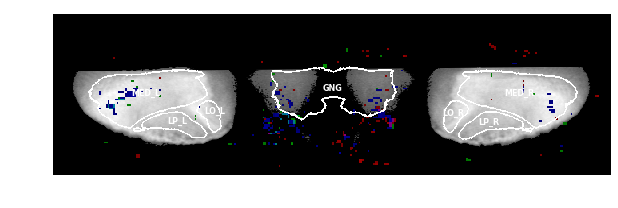

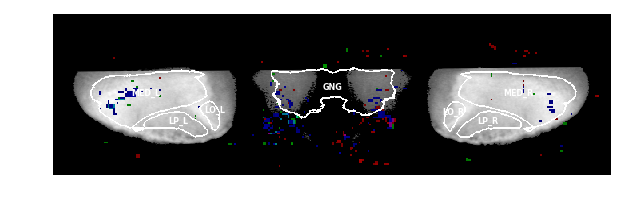

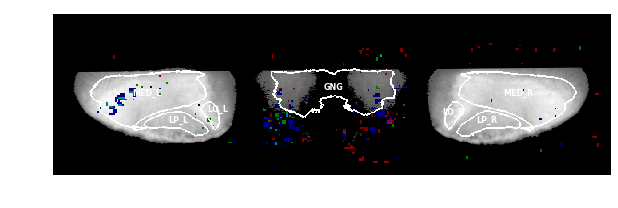

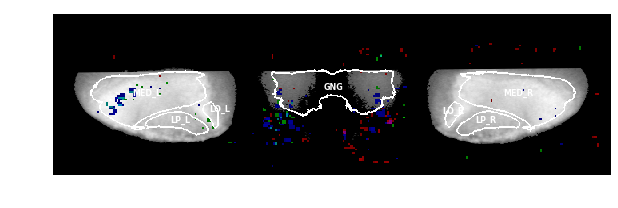

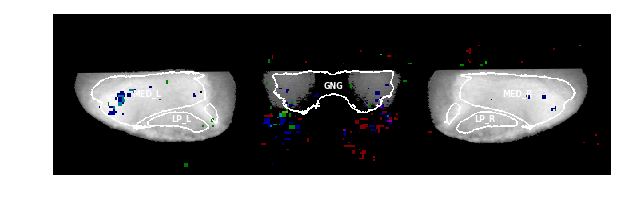

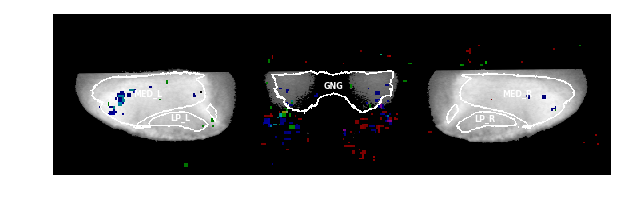

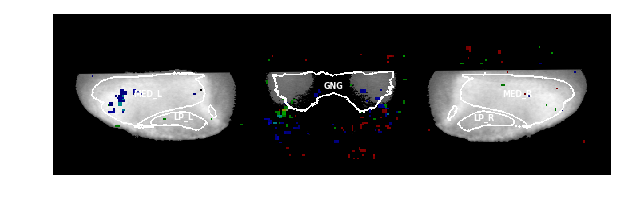

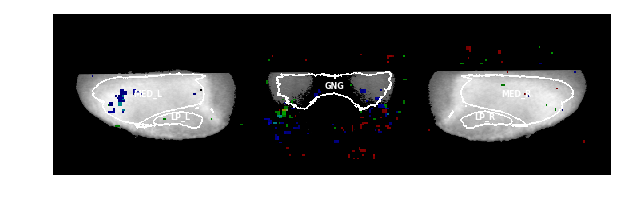

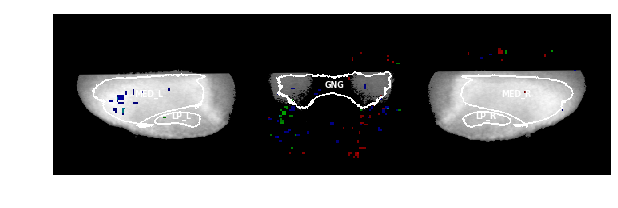

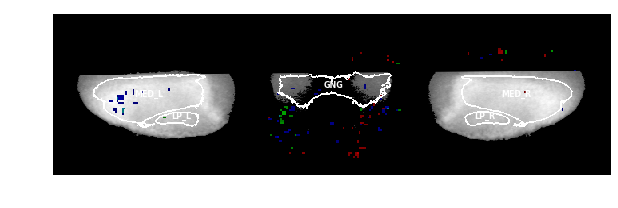

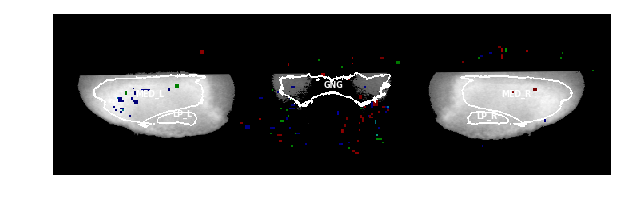

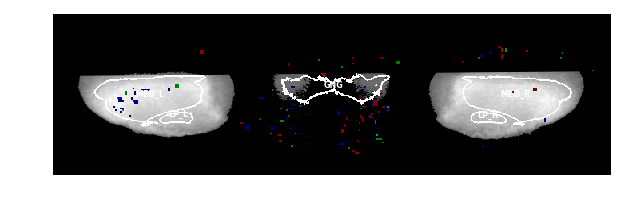

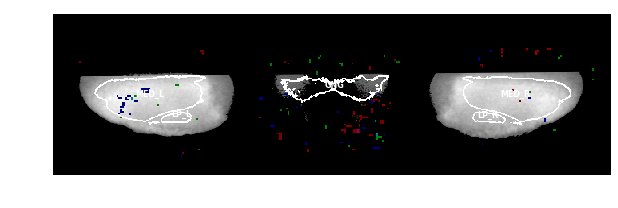

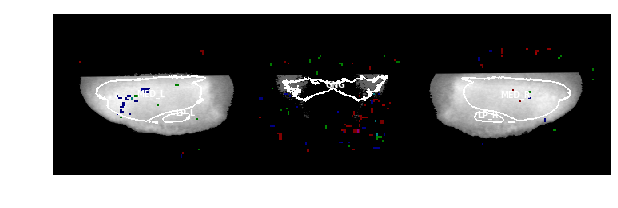

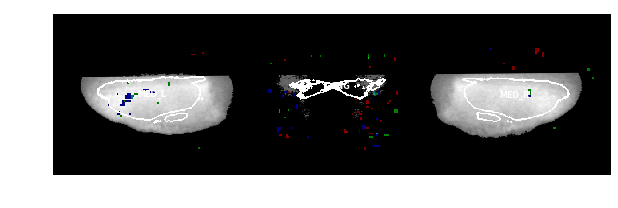

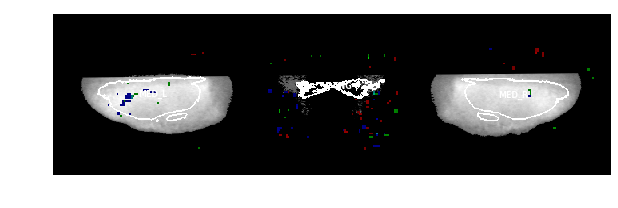

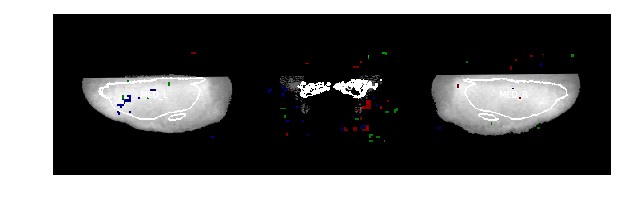

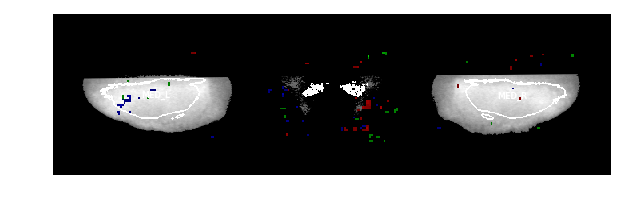

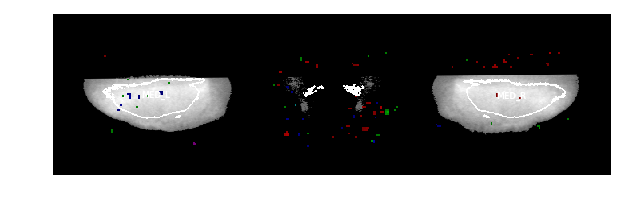

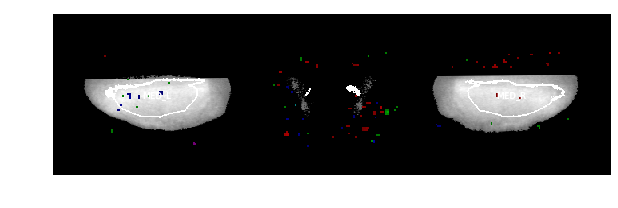

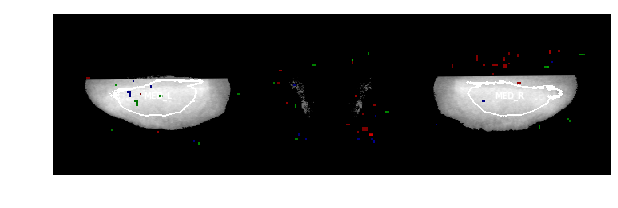

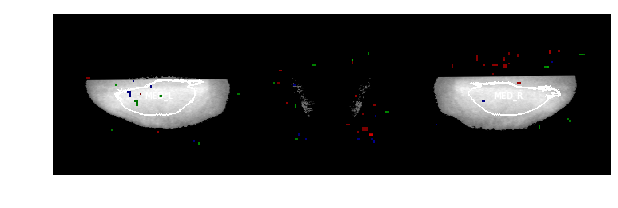

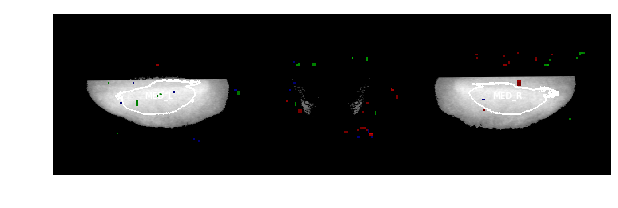

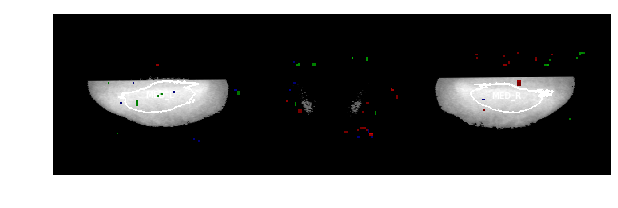

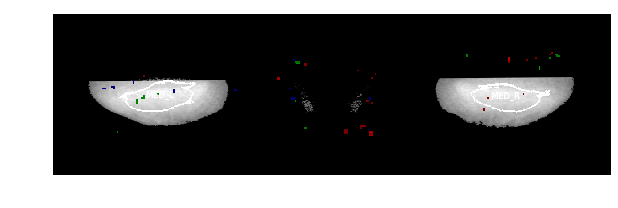

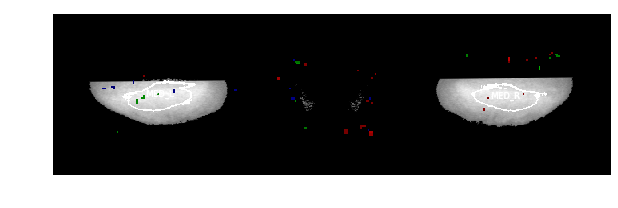

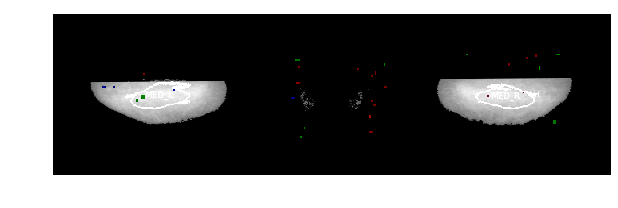

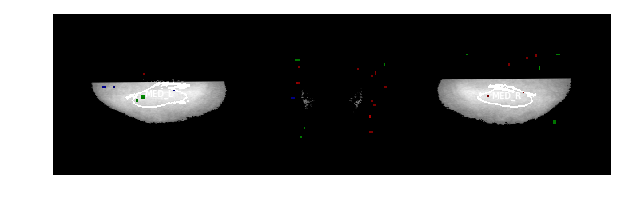

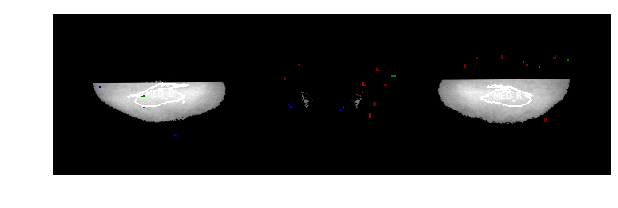

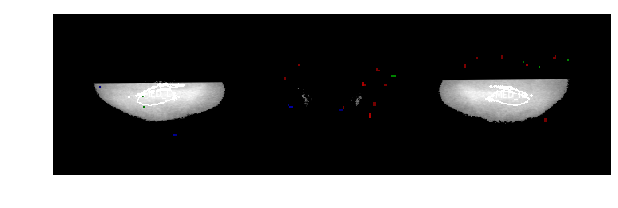

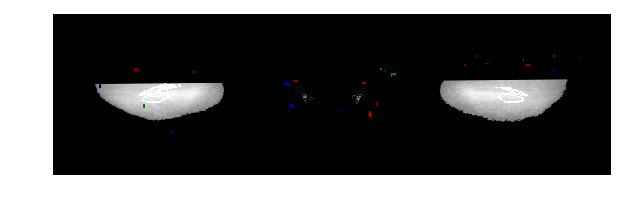

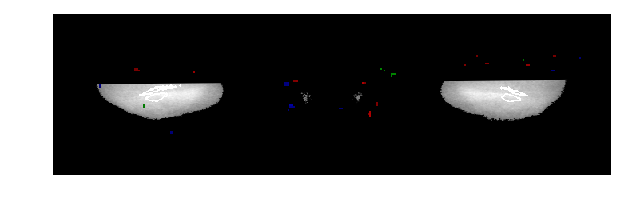

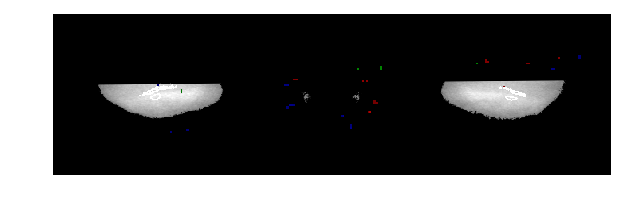

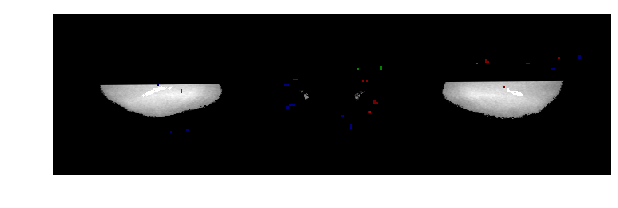

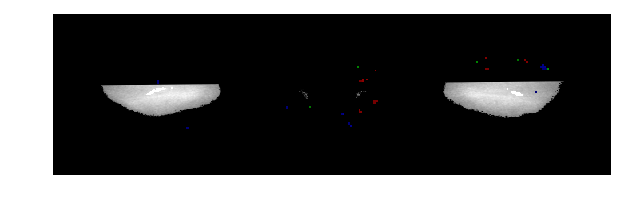

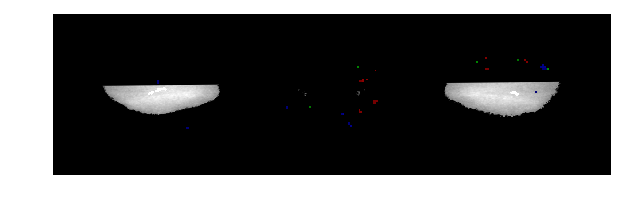

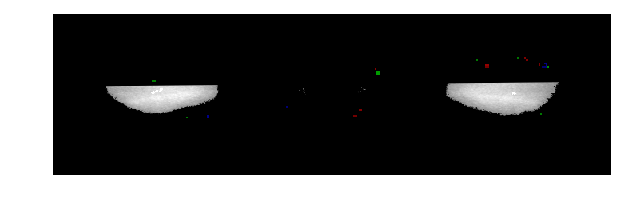

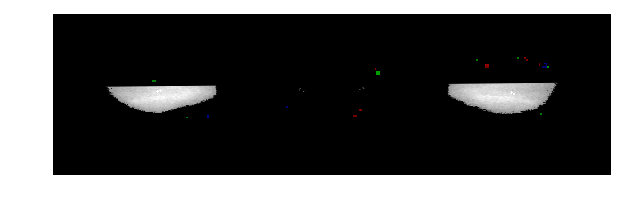

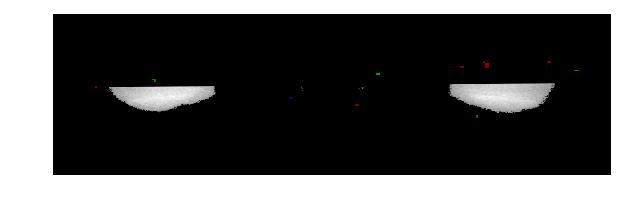

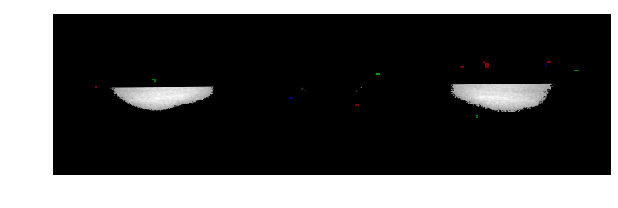

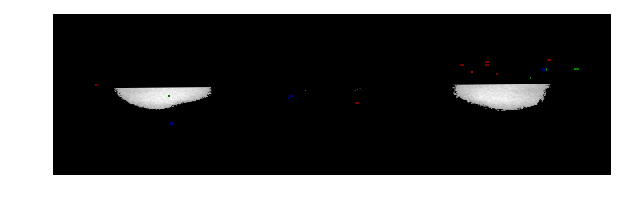

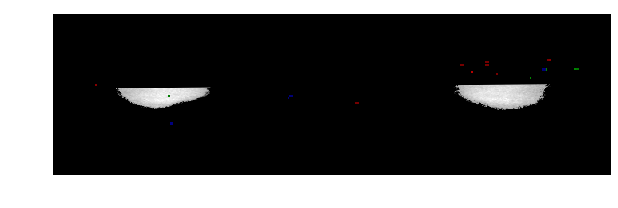

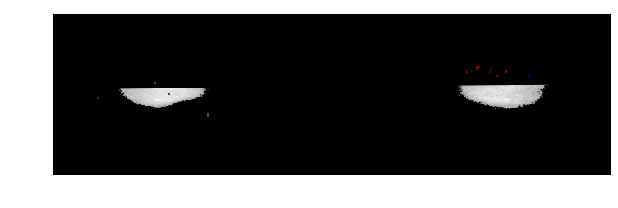

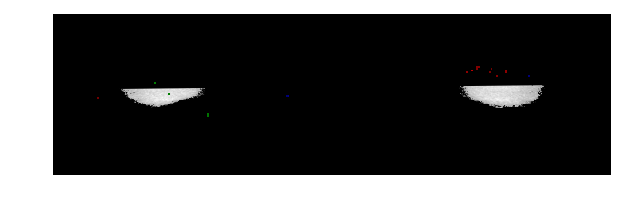

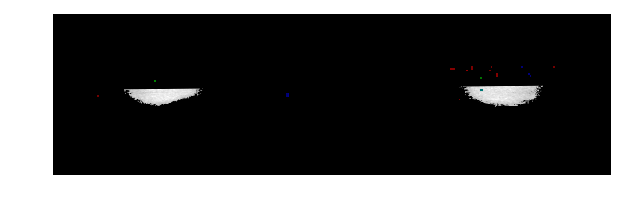

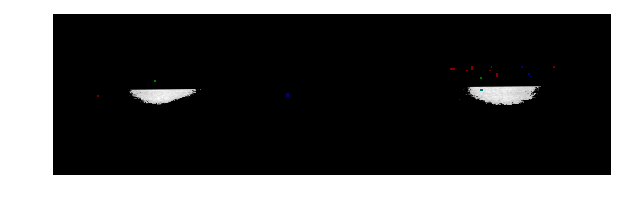

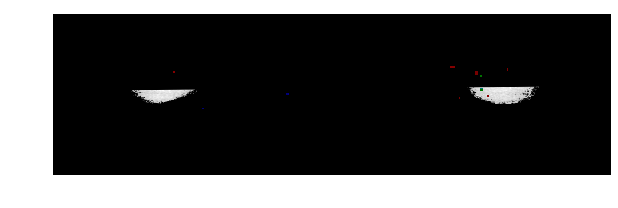

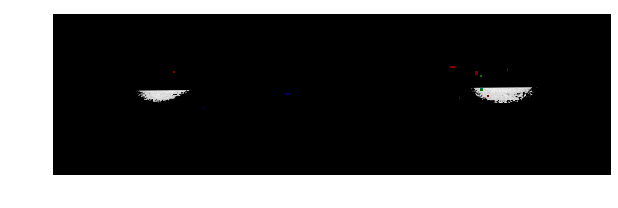

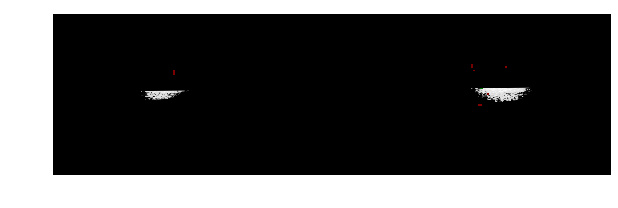

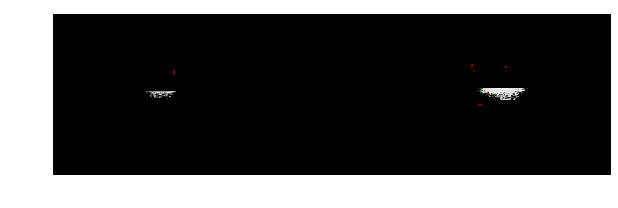

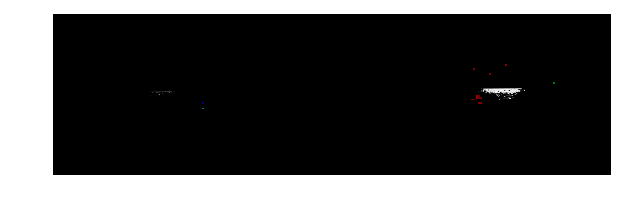

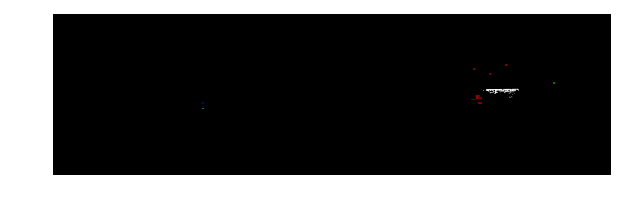

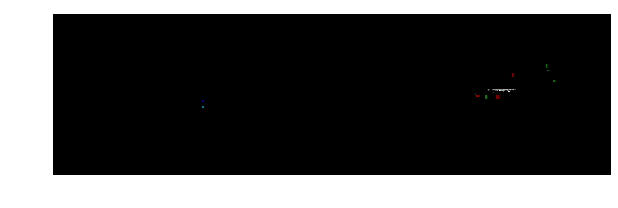

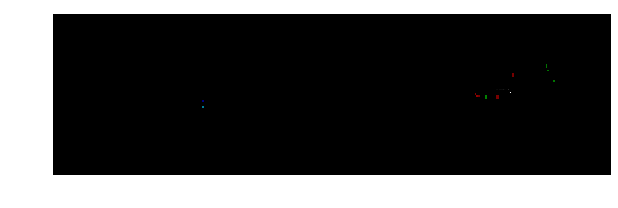

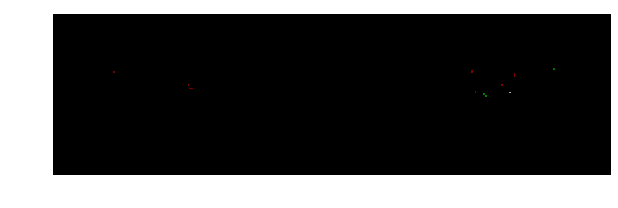

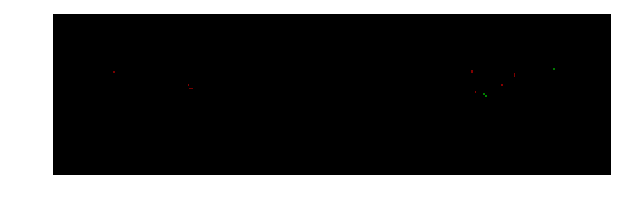

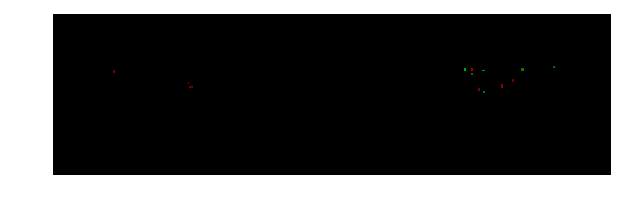

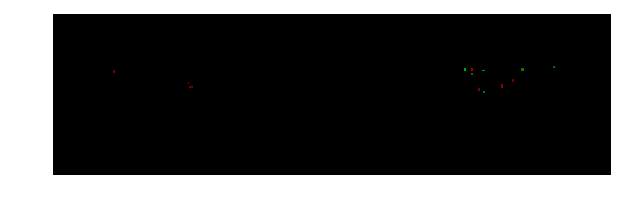

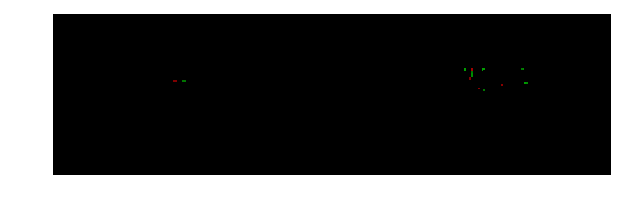

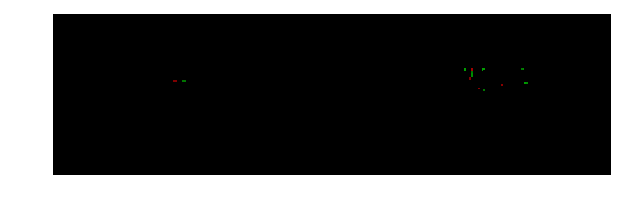

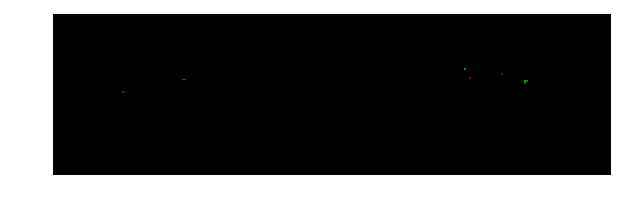

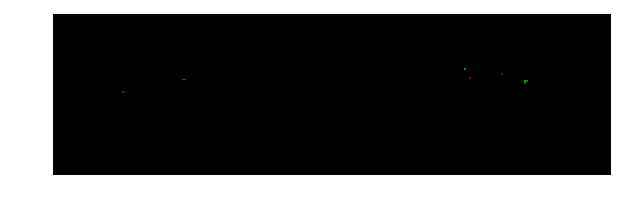

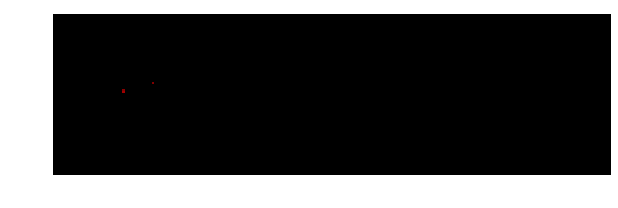

In [39]:
for z in range(360,584,2):
    print(z)
    # get edges for this slice
    edges = cv2.Canny(atlas_int[:,z,:],1,1)
    edges = binary_dilation(edges, iterations=1)
    edges = scipy.ndimage.median_filter(edges,2)
    edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

    plt.figure(figsize=(10,10))
    plt.imshow(highres_anat['warpedmovout'][:,z,:].T,cmap='gray')
    plt.imshow(np.swapaxes(signals_alpha[:,z,:,:]*20,0,1))
    plt.imshow(np.swapaxes(edges_,0,1)*10000)

    for roi in all_roi_labels[z]: #replace first 0 with z
        try:
            plt.text(x=all_roi_labels[z][roi][0], #replace first 0 with z
                     y=all_roi_labels[z][roi][1],
                     s=rois[roi],fontsize=8,ha='center',color='w',
                     fontweight='heavy')
        except KeyError:
            plt.text(x=all_roi_labels[z][roi][0],
                     y=all_roi_labels[z][roi][1],
                     s='?',fontsize=12,ha='center',color='w')

    plt.axis('off')
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210817_corr_video'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    label = format(z, '03d')
    fname = os.path.join(save_path, f'{label}')
    plt.savefig(fname,dpi=100,bbox_inches='tight')

In [31]:
os.mkdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210817_corr_video')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


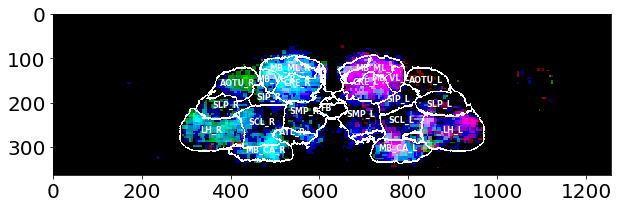

In [140]:
plt.figure(figsize=(10,10))
z=150

# get edges for this slice
edges = cv2.Canny(atlas_int[:,z,:],1,1)
edges = binary_dilation(edges, iterations=1)
edges = scipy.ndimage.median_filter(edges,2)
edges_ = np.repeat(edges.astype('int')[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

plt.imshow(np.swapaxes(maps_voxel_high_res[:,z,:,:]*20,0,1))
plt.imshow(np.swapaxes(edges_,0,1)*10000)

for roi in all_roi_labels[z]: #replace first 0 with z
    try:
        plt.text(x=all_roi_labels[z][roi][0], #replace first 0 with z
                 y=all_roi_labels[z][roi][1],
                 s=rois[roi],fontsize=8,ha='center',color='w',
                 fontweight='heavy')
    except KeyError:
        plt.text(x=all_roi_labels[z][roi][0],
                 y=all_roi_labels[z][roi][1],
                 s='?',fontsize=12,ha='center',color='w')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


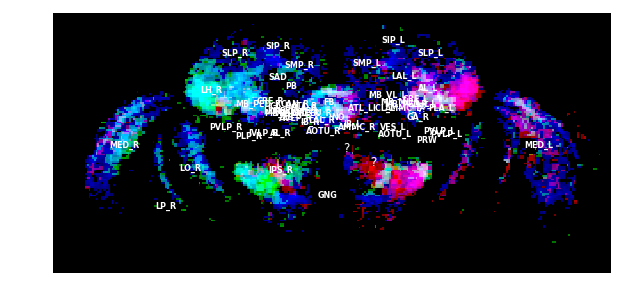

In [42]:
z=60
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*20,0,1))
#plt.imshow(np.swapaxes(atlas_contours[z,...],0,1))
plt.axis('off')

for roi in all_roi_labels[z]:
    try:
        plt.text(x=all_roi_labels[z][roi][0],
                 y=all_roi_labels[z][roi][1],
                 s=rois[roi],fontsize=8,ha='center',color='w',
                 fontweight='heavy')
    except KeyError:
        plt.text(x=all_roi_labels[z][roi][0],
                 y=all_roi_labels[z][roi][1],
                 s='?',fontsize=12,ha='center',color='w')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210629_corr_video'
timestr = time.strftime("%Y%m%d-%H%M%S")
label = format(z, '02d')
fname = os.path.join(save_path, f'{label}')
#plt.savefig(fname,dpi=100,bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


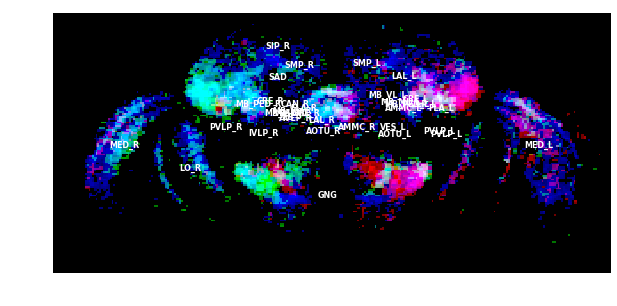

In [44]:
z=60
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*20,0,1))
#plt.imshow(np.swapaxes(atlas_contours[z,...],0,1))
plt.axis('off')

for roi in all_roi_labels[z]:
    try:
        plt.text(x=all_roi_labels[z][roi][0],
                 y=all_roi_labels[z][roi][1],
                 s=rois[roi],fontsize=8,ha='center',color='w',
                 fontweight='heavy')
    except KeyError:
        plt.text(x=all_roi_labels[z][roi][0],
                 y=all_roi_labels[z][roi][1],
                 s='?',fontsize=12,ha='center',color='w')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210629_corr_video'
timestr = time.strftime("%Y%m%d-%H%M%S")
label = format(z, '02d')
fname = os.path.join(save_path, f'{label}')
#plt.savefig(fname,dpi=100,bbox_inches='tight')